# Office Hours - 06/14/21 

## OFFICE HOURS BOOKMARK

- [06/14/21 Office Hours](#06-14-21_office_hours)
    - Click above to jump to header.
    
___

# Topic 38: Time Series Models

- 06/02/21
- onl01-dtsc-ft-022221

## Learning Objectives:

- Introduce time series models.
- Discuss basic time series models/types (white noise, random walk)
- Learn about autocorrelation and seasonality. (PACF, ACF)
- Introduce ARMA/ARIMA and SARIMA models.
    - Deep dive into getting predictions/forecasts. 
- Activity: Modeling Baltimore Crime with statsmodels

## Questions

- Is it possible to run an AR(3,0) model and seeing that Lag 2 was insignificant run an AR model on Lag 1 and Lag 3 (essentially, can you exclude intermediary lags)
- What is the significance of the white noise and random walk models? 
    - Would we run them as 'dummy' models to compare performance of our AR models? Or are these types of time series that we could encounter in real data that can't really be modeled very well?
- Can you talk a little more about interpreting the ACF and PACF plots and how they can help us decide on the right parameters for AR and MA? The sarima lab has us do a grid search… why might we do that if selecting appropriate parameters can be done from looking at the ACF and PACF plots?
- Can you explain whether there is a mathematical reason to shifting/differencing and what they achieve? Shifting/differencing the time series seems a little arbitrary.
- Is it possible to overfit a time series model?


# Revisiting Baltimore Crime from Topic 37

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from random import gauss

pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = [12,5]

## Plotly Express
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Statmodels time series analysis 
import statsmodels.tsa.api as tsa

In [2]:
pwd

'/Users/jamesirving/Documents/GitHub/_COHORT_NOTES/022221FT/Online-DS-FT-022221-Cohort-Notes/Phase_4/phase_4_project/time-series'

In [3]:
## appending folder with functions
import sys
sys.path.append("../../topic_38_time_series_models/")

## Functions from Last Class 
%load_ext autoreload
%autoreload 2
import ts_functions as tsf

### Loading in Time Series

In [4]:
## Load in file and parse_dates, check index
file ="https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/baltimore_crime_counts_2021.csv"
df = pd.read_csv(file,parse_dates=True, index_col='CrimeDateTime')
display(df.head(),df.index)

HOMICIDE  AGG. ASSAULT  COMMON ASSAULT  LARCENY  \
CrimeDateTime                                                                
2014-01-01 00:00:00+00:00         2            22              19       34   
2014-01-02 00:00:00+00:00         3             6              23       26   
2014-01-03 00:00:00+00:00         1            11              17       16   
2014-01-04 00:00:00+00:00         0            14              23       23   
2014-01-05 00:00:00+00:00         0             9              22       19   

                           AUTO THEFT  ROBBERY - CARJACKING  BURGLARY  \
CrimeDateTime                                                           
2014-01-01 00:00:00+00:00           9                   0.0        20   
2014-01-02 00:00:00+00:00           7                   1.0        28   
2014-01-03 00:00:00+00:00           3                   0.0        13   
2014-01-04 00:00:00+00:00          14                   0.0        20   
2014-01-05 00:00:00+00:00          11                   2.0        14   

                           LARCENY FROM AUTO  ROBBERY - COMMERCIAL  SHOOTING  \
CrimeDateTime                                                                  
2014-01-01 00:00:00+00:00                 15                     2         2   
2014-01-02 00:00:00+00:00                 10                     1         0   
2014-01-03 00:00:00+00:00                  6                     1         1   
2014-01-04 00:00:00+00:00                 15                     1         0   
2014-01-05 00:00:00+00:00                 13                     0         2   

                           ROBBERY - RESIDENCE  ROBBERY - STREET  ARSON  RAPE  
CrimeDateTime                                                                  
2014-01-01 00:00:00+00:00                  1.0               8.0    0.0   5.0  
2014-01-02 00:00:00+00:00                  1.0               4.0    0.0   0.0  
2014-01-03 00:00:00+00:00                  1.0               2.0    0.0   0.0  
2014-01-04 00:00:00+00:00                  1.0               7.0    0.0   0.0  
2014-01-05 00:00:00+00:00                  1.0              10.0    0.0   1.0

DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-02 00:00:00+00:00',
               '2014-01-03 00:00:00+00:00', '2014-01-04 00:00:00+00:00',
               '2014-01-05 00:00:00+00:00', '2014-01-06 00:00:00+00:00',
               '2014-01-07 00:00:00+00:00', '2014-01-08 00:00:00+00:00',
               '2014-01-09 00:00:00+00:00', '2014-01-10 00:00:00+00:00',
               ...
               '2021-05-13 00:00:00+00:00', '2021-05-14 00:00:00+00:00',
               '2021-05-15 00:00:00+00:00', '2021-05-16 00:00:00+00:00',
               '2021-05-17 00:00:00+00:00', '2021-05-18 00:00:00+00:00',
               '2021-05-19 00:00:00+00:00', '2021-05-20 00:00:00+00:00',
               '2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=2699, freq=None)

> - If data is already in the frequency desired, can use `.resample("D").asfreq()` instead of an aggregation function

In [5]:
## resample.asfreq
df = df.resample('D').asfreq()
df.index

DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-02 00:00:00+00:00',
               '2014-01-03 00:00:00+00:00', '2014-01-04 00:00:00+00:00',
               '2014-01-05 00:00:00+00:00', '2014-01-06 00:00:00+00:00',
               '2014-01-07 00:00:00+00:00', '2014-01-08 00:00:00+00:00',
               '2014-01-09 00:00:00+00:00', '2014-01-10 00:00:00+00:00',
               ...
               '2021-05-13 00:00:00+00:00', '2021-05-14 00:00:00+00:00',
               '2021-05-15 00:00:00+00:00', '2021-05-16 00:00:00+00:00',
               '2021-05-17 00:00:00+00:00', '2021-05-18 00:00:00+00:00',
               '2021-05-19 00:00:00+00:00', '2021-05-20 00:00:00+00:00',
               '2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=2699, freq='D')

In [6]:
## Get a list of crimes to remind ourselves what we have
df.sum().sort_values(ascending=False)

LARCENY                 74681.0
COMMON ASSAULT          57451.0
BURGLARY                46935.0
LARCENY FROM AUTO       43223.0
AGG. ASSAULT            38478.0
AUTO THEFT              29502.0
ROBBERY - STREET        23056.0
ROBBERY - COMMERCIAL     5872.0
SHOOTING                 4777.0
ROBBERY - RESIDENCE      3590.0
ROBBERY - CARJACKING     3128.0
HOMICIDE                 2311.0
RAPE                     2236.0
ARSON                    1409.0
dtype: float64

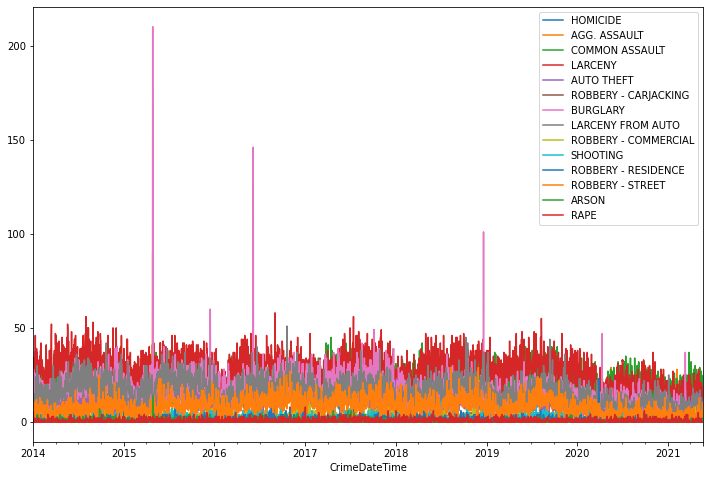

In [7]:
## Plot the weekly dataset to identify which ts to model
ax = df.plot(figsize=(12,8)) 
ax.legend(bbox_to_anchor=[1,1])

> For modeling purposes, we are going to focus on **Weekly crime** forecasts instead of daily, so we will resample to Weekly freq.

In [8]:
## Lets resample the df to Weekly and save as new dfw
# also, let's take 2018 - present for ~3 years of data
dfw = df.resample('W').sum().loc['2017':]

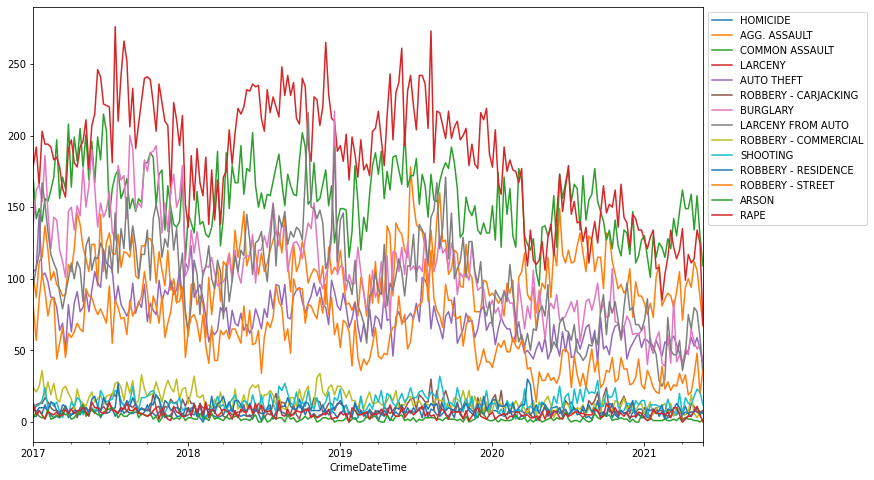

In [9]:
## Plot the weekly dataset to identify which ts to model
ax = dfw.plot(figsize=(12,8)) 
ax.legend(bbox_to_anchor=[1,1])

> #### Theres a lot of lines to sift through so lets use plotly express to make it easier


In [10]:
# use px.line 
px.line(dfw)

- Before we dive into modeling crime, let's discuss the simplest time series models. 

# Basic Time Series models

## Simplest Time Series Models

- White Noise Model
- Random Walk Model

### White Noise Model
- 3 Properties:
    - Fixed and constant mean
    - Fixed and constant variance
    - No correlation over time

$$\Large Y_t =  \epsilon_t$$

The error term is randomly distributed around the mean, has constant variance, and no autocorrelation.

- Gaussian White Noise: A special case of a White Noise model is 
    - Mean is equal to zero
    - variance is equal to 1
    $$\large Y_t = \epsilon_t + \theta * \epsilon_{t-1}$$

(-0.03392836948117868, 0.9241420290314655)

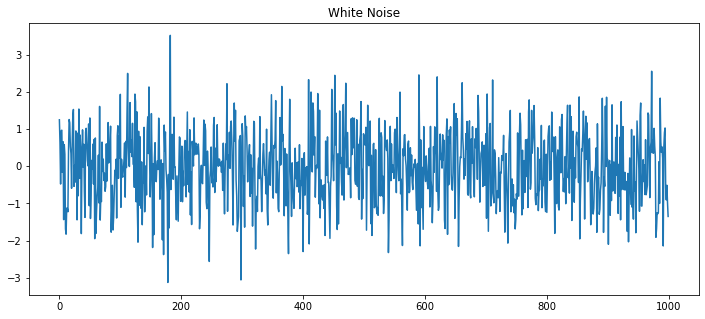

In [11]:
## White noise has mean=0, variance =1
mean = 0
variance = 1

## Make a white noise time series
noise = pd.Series([gauss(mean, np.sqrt(variance)) for x in range(1000)])
noise.plot(title='White Noise')

## Check our mean and variance
noise.mean(),noise.var()

#### Verify White Noise 

##### From 2015 scipy conference paper https://conference.scipy.org/proceedings/scipy2015/pdfs/margaret_mahan.pdf
- Use windows of 10% to asses white noise

In [12]:
## Calc 10% of time steps/lags
window = round(len(noise)*.10)
window

100

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -28.586           0                     999   

                   p-value  p<.05  Stationary?  
AD Fuller Results      0.0   True         True

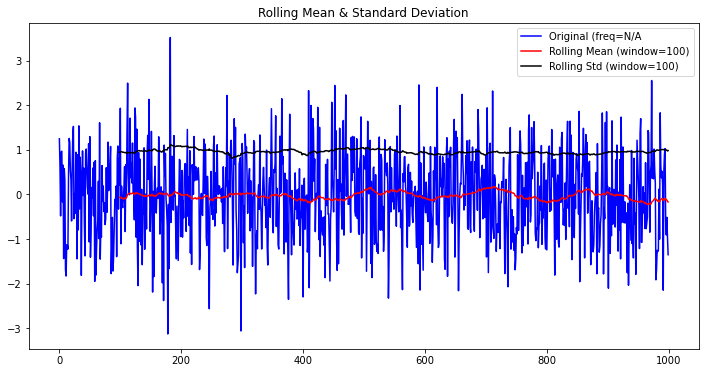

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -28.586           0                     999   

                   p-value  p<.05  Stationary?  
AD Fuller Results      0.0   True         True

In [13]:
## Check if white noise
tsf.stationarity_check(noise, window=window)

### Random Walk Model
- Two Properties:
    - Has no specified mean or variance
    - Has a strong dependence over time

- Mathematically, this can be written as:

$$\large Y_t = Y_{t-1} + \epsilon_t$$

- Where $\epsilon_t$ is a *mean zero* white noise model

- Random Walk with a Drift":
    - a drift parameter $c$, steering in a certain direction.
$$\large Y_t = c + Y_{t-1} + \epsilon_t$$

<AxesSubplot:>

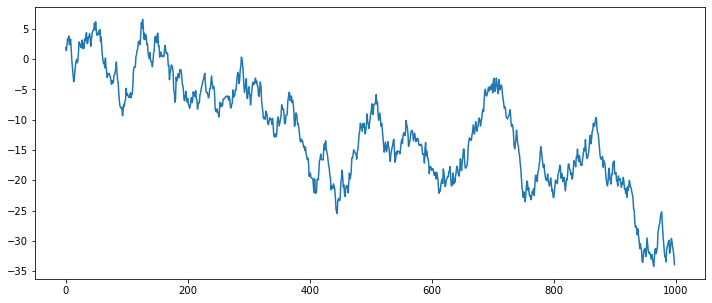

In [14]:
## Using white noise to simulate a random walk
#https://campus.datacamp.com/courses/time-series-analysis-in-python/some-simple-time-series?ex=7
walk = noise.shift(-1)+noise.cumsum()
walk.plot()

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results             NaN           0                     999   

                   p-value  p<.05  Stationary?  
AD Fuller Results      NaN  False        False

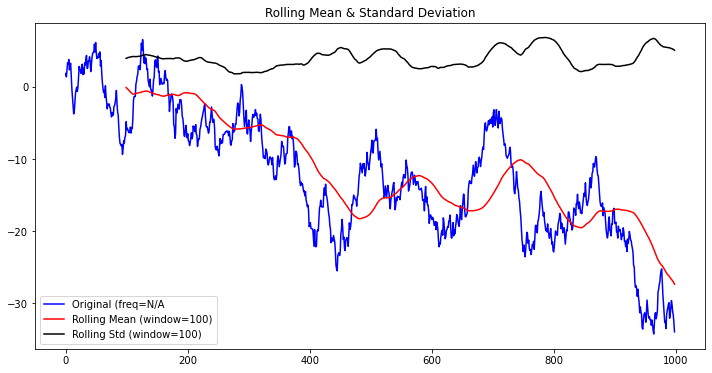

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results             NaN           0                     999   

                   p-value  p<.05  Stationary?  
AD Fuller Results      NaN  False        False

In [15]:
## Check if random walk is stationary
tsf.stationarity_check(walk, window=window)

- When a random walk is differenced it returns a white noise. 

This is a result of the mathematical formula:

$$Y_t = Y_{t-1} + \epsilon_t$$
which is equivalent to
$$Y_t - Y_{t-1} = \epsilon_t$$

and we know that $\epsilon_t$ is a mean-zero white noise process! 

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -28.545           0                     997   

                   p-value  p<.05  Stationary?  
AD Fuller Results      0.0   True         True

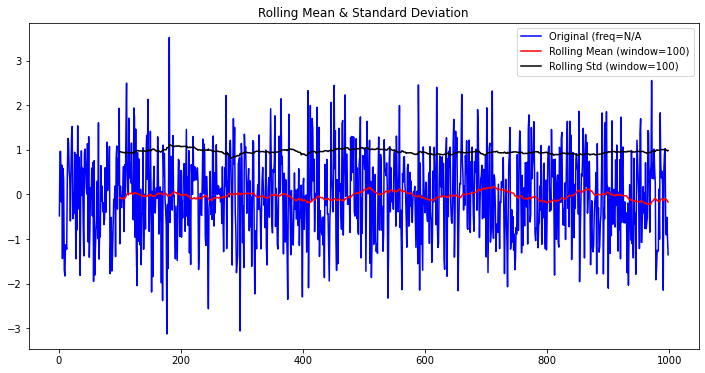

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -28.545           0                     997   

                   p-value  p<.05  Stationary?  
AD Fuller Results      0.0   True         True

In [16]:
## Confirm walk differenced returns a white noise
tsf.stationarity_check(walk.diff().dropna(),window=window)

## Finding Basic Time Series in Baltimore Crimes

### Identifying Crimes Optimal for Different Types of Times Series Models


- Using the plotly plot, explore individual crimes to identify which crimes are appropriate for the different types of time series models.
- Then confirm using stationarity check

- White Noise: ___
- Random Walk: ___

In [17]:
## re-plot dfw and identify crimes that follow a white nosie or random walk model
px.line(dfw)

In [18]:
### Identifying Crimes Optimal for Different Types of Times Series Models
ts_cols= {'white noise':dfw['HOMICIDE'],
         'random walk': dfw['LARCENY']}

### Check Our White Noise Crime

In [19]:
## Calc 10% of time steps/lags
window = round(len(dfw)*.10)
window

23

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -14.903           0                     229   

                     p-value  p<.05  Stationary?  
AD Fuller Results  1.497e-27   True         True

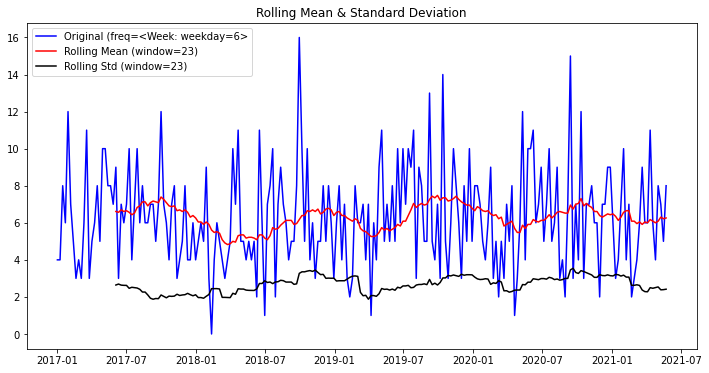

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -14.903           0                     229   

                     p-value  p<.05  Stationary?  
AD Fuller Results  1.497e-27   True         True

In [20]:
## Visualize white noise-like ts
tsf.stationarity_check(ts_cols['white noise'], window=window)

### Check Our Random Walk Crime

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results          -1.528           2                     227   

                   p-value  p<.05  Stationary?  
AD Fuller Results    0.519  False        False

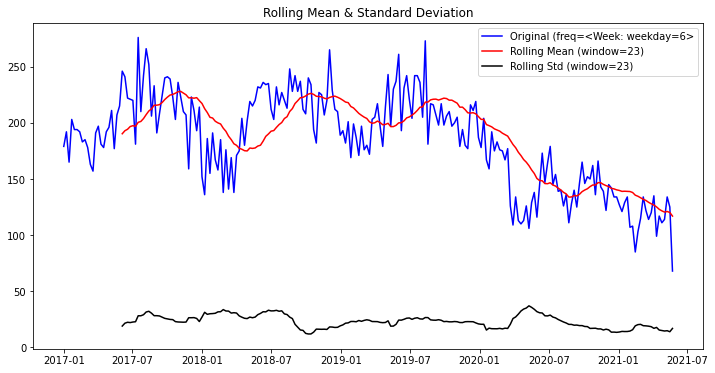

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results          -1.528           2                     227   

                   p-value  p<.05  Stationary?  
AD Fuller Results    0.519  False        False

In [21]:
## Visualize random-walk ts
## Visualize white noise-like ts
tsf.stationarity_check(ts_cols['random walk'], window=window)

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -17.019           1                     227   

                     p-value  p<.05  Stationary?  
AD Fuller Results  8.480e-30   True         True

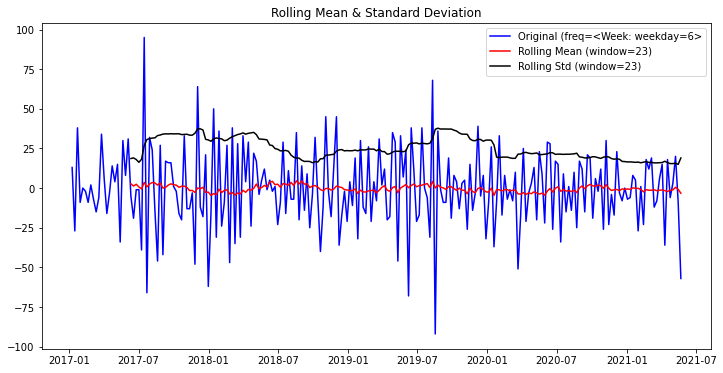

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results         -17.019           1                     227   

                     p-value  p<.05  Stationary?  
AD Fuller Results  8.480e-30   True         True

In [22]:
## Check if our random walk is stationary
tsf.stationarity_check(ts_cols['random walk'].diff().dropna(), window=window)

In [23]:
## confirm our random walk becomes stationary white noise


# Correlation, Autocorrelation & Partial Autocorrelation

> Time Series that are correlated with themselves (autocorrelation) are best suited for a more complex modeling approach.

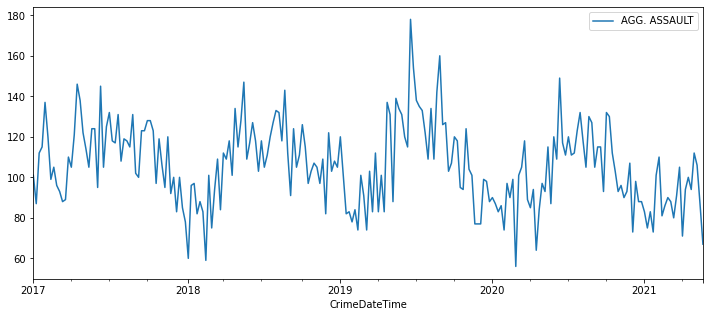

In [24]:
## Use AGG. ASSAULT as ts 
crime = "AGG. ASSAULT"
ts = dfw[crime]
ts.plot()
plt.legend()

## Exploring Autocorrelation 

<AxesSubplot:xlabel='CrimeDateTime'>

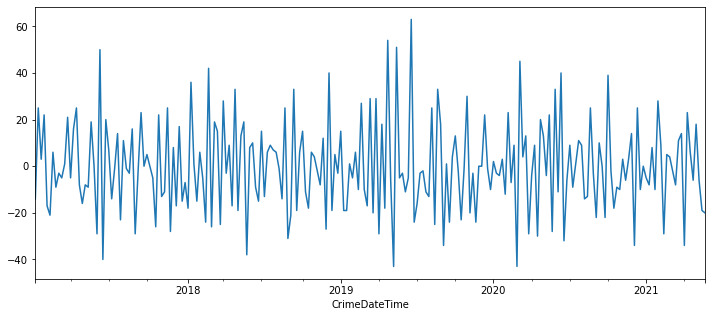

In [25]:
## Save differenced version and plot
ts_diff = ts.diff().dropna()
ts_diff.plot()

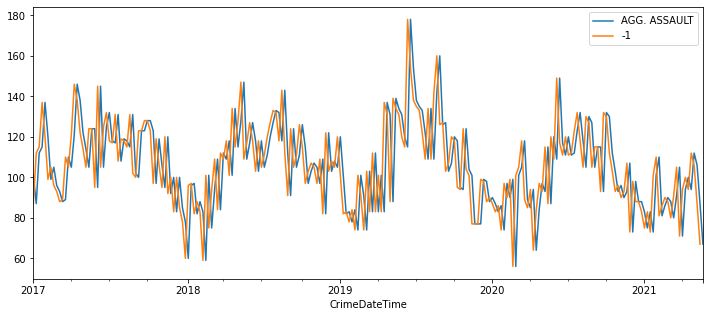

In [26]:
## Shift the ts_orig by -1 time lag
lag = -1
ts_shift = ts.shift(lag).dropna().rename(f"{lag}")

## Plot original ts vs shifted
ax = ts.plot()
ts_shift.plot(ax=ax)
ax.legend()


In [27]:
pd.concat([ts,ts_shift],axis=1).corr()

AGG. ASSAULT     -1
AGG. ASSAULT         1.000  0.527
-1                   0.527  1.000

In [28]:
ts_diff = ts.diff().dropna()
ts_diff

CrimeDateTime
2017-01-08 00:00:00+00:00   -14.0
2017-01-15 00:00:00+00:00    25.0
2017-01-22 00:00:00+00:00     3.0
2017-01-29 00:00:00+00:00    22.0
2017-02-05 00:00:00+00:00   -17.0
                             ... 
2021-04-25 00:00:00+00:00    -6.0
2021-05-02 00:00:00+00:00    18.0
2021-05-09 00:00:00+00:00    -6.0
2021-05-16 00:00:00+00:00   -19.0
2021-05-23 00:00:00+00:00   -20.0
Freq: W-SUN, Name: AGG. ASSAULT, Length: 229, dtype: float64

<AxesSubplot:xlabel='CrimeDateTime'>

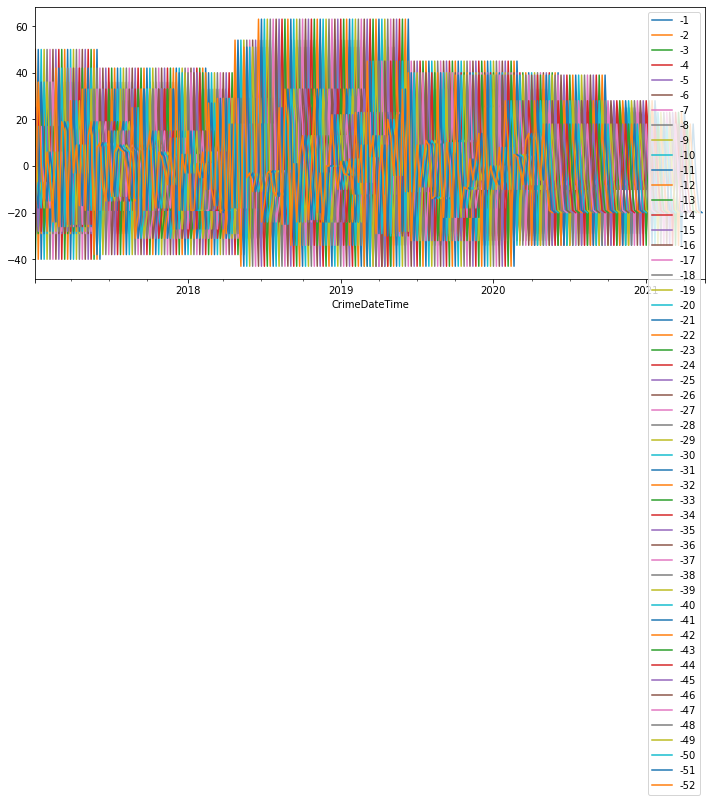

In [29]:
## Shift the orig ts from -1 to -52 lags

lags = list(range(-1,-53,-1))
shifted_ts = pd.concat([ts_diff.shift(lag).rename(f'{lag}') for lag in lags],axis=1)

shifted_ts.plot()

In [30]:
ts_corrs = pd.concat([ts_diff,shifted_ts],axis=1).corr()
ts_corrs

AGG. ASSAULT         -1     -2     -3     -4     -5     -6  \
AGG. ASSAULT         1.000 -4.751e-01  0.011  0.062 -0.091  0.056 -0.064   
-1                  -0.475  1.000e+00 -0.473  0.011  0.066 -0.094  0.052   
-2                   0.011 -4.732e-01  1.000 -0.476  0.005  0.071 -0.088   
-3                   0.062  1.138e-02 -0.476  1.000 -0.478  0.005  0.072   
-4                  -0.091  6.559e-02  0.005 -0.478  1.000 -0.476  0.011   
-5                   0.056 -9.410e-02  0.071  0.005 -0.476  1.000 -0.482   
-6                  -0.064  5.246e-02 -0.088  0.072  0.011 -0.482  1.000   
-7                   0.080 -6.324e-02  0.051 -0.089  0.070  0.012 -0.482   
-8                  -0.106  7.880e-02 -0.061  0.051 -0.087  0.069  0.010   
-9                   0.094 -1.069e-01  0.080 -0.061  0.052 -0.087  0.068   
-10                  0.015  9.350e-02 -0.106  0.080 -0.060  0.051 -0.089   
-11                 -0.081  1.521e-02  0.094 -0.106  0.080 -0.060  0.052   
-12                  0.174 -7.745e-02  0.009  0.093 -0.112  0.085 -0.055   
-13                 -0.211  1.733e-01 -0.076  0.009  0.095 -0.113  0.084   
-14                  0.183 -2.091e-01  0.169 -0.077  0.005  0.098 -0.110   
-15                 -0.150  1.880e-01 -0.218  0.169 -0.084  0.010  0.105   
-16                 -0.021 -1.519e-01  0.191 -0.218  0.172 -0.086  0.008   
-17                  0.120 -2.342e-02 -0.148  0.192 -0.215  0.169 -0.091   
-18                 -0.068  1.187e-01 -0.021 -0.148  0.195 -0.217  0.167   
-19                 -0.017 -6.939e-02  0.122 -0.021 -0.146  0.193 -0.220   
-20                  0.065 -1.369e-02 -0.076  0.121 -0.026 -0.142  0.199   
-21                  0.007  6.485e-02 -0.014 -0.076  0.122 -0.026 -0.143   
-22                 -0.214  2.214e-03  0.074 -0.013 -0.068  0.117 -0.034   
-23                  0.197 -2.091e-01 -0.014  0.074 -0.027 -0.059  0.132   
-24                  0.024  1.918e-01 -0.199 -0.012  0.086 -0.036 -0.070   
-25                 -0.181  2.802e-02  0.187 -0.201 -0.018  0.091 -0.031   
-26                  0.165 -1.802e-01  0.026  0.186 -0.204 -0.017  0.093   
-27                 -0.138  1.631e-01 -0.177  0.026  0.191 -0.207 -0.020   
-28                  0.061 -1.379e-01  0.164 -0.177  0.027  0.191 -0.208   
-29                  0.004  6.328e-02 -0.143  0.164 -0.182  0.030  0.196   
-30                  0.030  3.292e-04  0.071 -0.143  0.171 -0.188  0.024   
-31                 -0.054  3.191e-02 -0.003  0.071 -0.147  0.174 -0.185   
-32                 -0.013 -5.411e-02  0.032 -0.003  0.071 -0.147  0.175   
-33                  0.016 -1.350e-02 -0.053  0.032 -0.003  0.071 -0.148   
-34                 -0.066  1.867e-02 -0.019 -0.054  0.028  0.001  0.076   
-35                  0.138 -7.152e-02  0.028 -0.018 -0.046  0.022 -0.007   
-36                 -0.145  1.374e-01 -0.071  0.028 -0.017 -0.047  0.021   
-37                  0.067 -1.413e-01  0.131 -0.072  0.022 -0.012 -0.041   
-38                  0.041  6.685e-02 -0.142  0.131 -0.073  0.022 -0.012   
-39                 -0.089  4.186e-02  0.065 -0.142  0.130 -0.072  0.023   
-40                  0.103 -8.931e-02  0.042  0.065 -0.143  0.130 -0.072   
-41                 -0.092  1.024e-01 -0.088  0.042  0.067 -0.144  0.129   
-42                  0.027 -9.792e-02  0.112 -0.087  0.050  0.061 -0.153   
-43                  0.086  3.163e-02 -0.106  0.112 -0.095  0.056  0.068   
-44                 -0.111  8.354e-02  0.036 -0.106  0.116 -0.098  0.052   
-45                 -0.036 -1.130e-01  0.088  0.037 -0.103  0.114 -0.102   
-46                  0.070 -3.087e-02 -0.123  0.087  0.029 -0.098  0.122   
-47                  0.135  6.548e-02 -0.022 -0.122  0.096  0.023 -0.107   
-48                 -0.221  1.371e-01  0.063 -0.022 -0.125  0.099  0.025   
-49                  0.125 -2.249e-01  0.144  0.064 -0.017 -0.130  0.094   
-50                  0.007  1.292e-01 -0.232  0.143  0.059 -0.013 -0.125   
-51                 -0.092  3.998e-03  0.135 -0.232  0.149  0.

<AxesSubplot:>

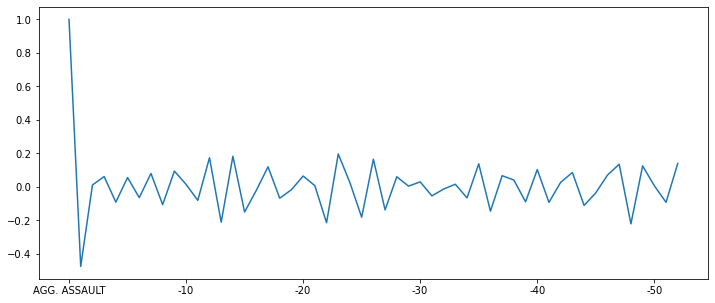

In [31]:
## Plot the correlations 

ts_corrs.loc['AGG. ASSAULT'].plot()

## ACF & PACF  Plots

### Autocorrelation Function Plots

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

> - "The **autocorrelation function** is a function that represents autocorrelation of a time series as a function of the time lag."
- The autocorrelation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

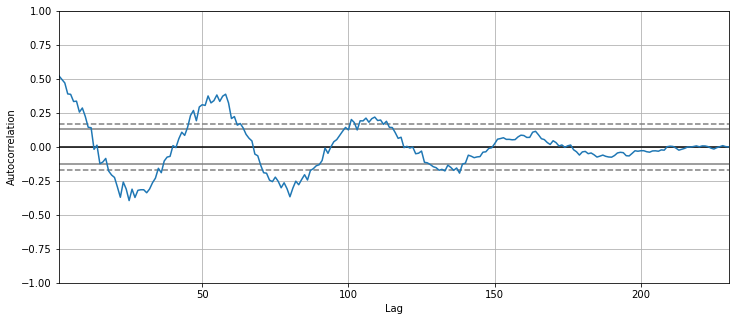

In [32]:
## Use panda's autocorrelation plot on the ts
pd.plotting.autocorrelation_plot(ts)

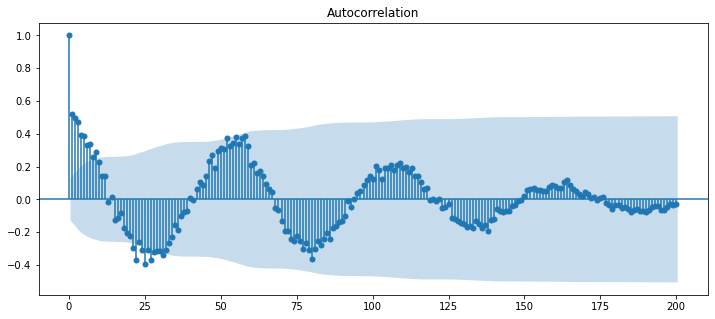

In [33]:
## Use statsmodels ACF plot on ts
tsa.graphics.plot_acf(ts,lags=200);

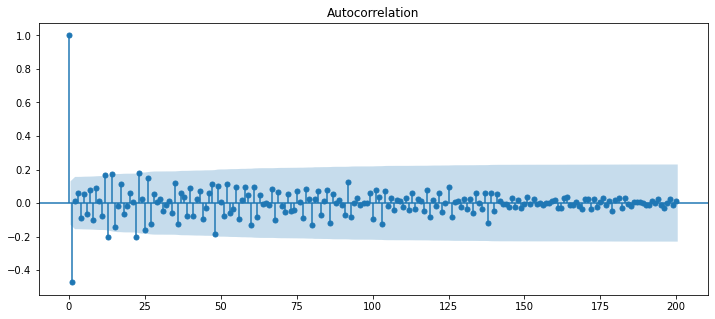

In [34]:
## Use plot_acf on ts_diff
tsa.graphics.plot_acf(ts_diff,lags=200);

### Partial-Autocorrelation Function Plot


> "The **partial autocorrelation function** can be interpreted as a regression of the series against its past lags.
 
 > It helps you come up with a possible order for the auto regressive term. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. "

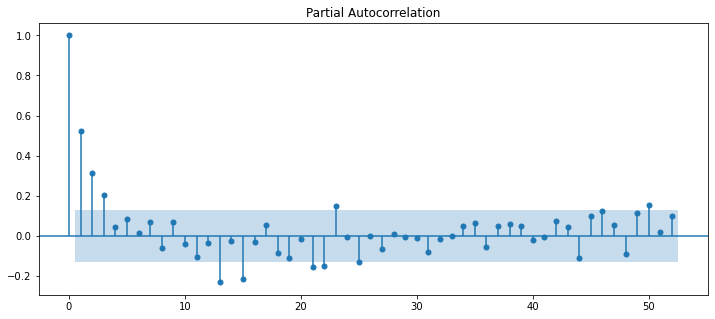

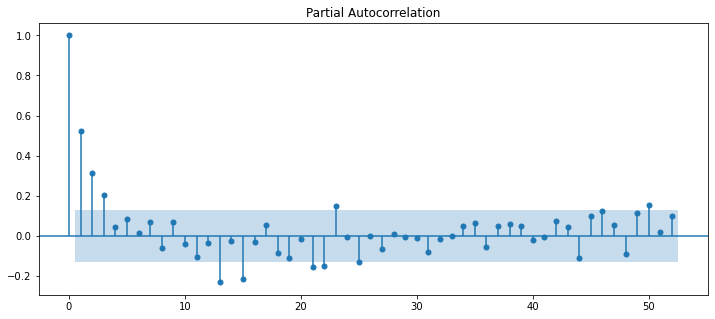

In [35]:
## Use plot_pacf on ts
tsa.graphics.plot_pacf(ts,lags=52)

>- From Central Lecturer: gradual persistent autocorrelations in ACF indicate that differencing should be applied.

In [36]:
## Use plot_pacf on ts_diff


### def  `plot_acf_pacf`

In [37]:
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='x',which='both') for ax in axes]
    
    if suptitle is not None:
        fig.suptitle(suptitle,y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,ax
    

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

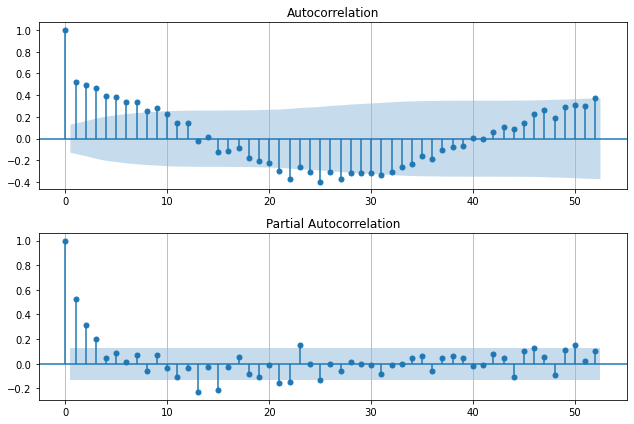

In [38]:
## Use function on original data
plot_acf_pacf(ts)

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

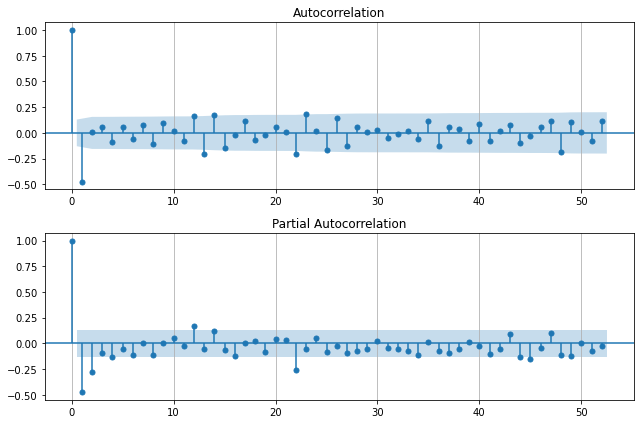

In [39]:
## Use function on differenced data
plot_acf_pacf(ts_diff)

> When time series show autocorrelation, it is an indicator to use more complex time series models.

#  Time Series Modeling with `statsmodels`

## AR/MA MODELS

### Autoregressive Model (AR)



An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

In words, the mathematical idea is the following:

$$ \text{Today = constant + slope} \times \text{yesterday + noise} $$

Or, mathematically:
$$\large Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follows an oscillatory process


<!---

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_model.png">

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-arma-models-online-ds-pt-100719/master/images/AR_PACF.png"> --->

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  229
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -974.318
Date:                Mon, 14 Jun 2021   AIC                           1954.635
Time:                        13:48:51   BIC                           1964.936
Sample:                    01-08-2017   HQIC                          1958.791
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1006      0.781     -0.129      0.898      -1.632       1.431
ar.L1         -0.4746      0.059     -8.060      0.000      -0.590      -0.359
sigma2       290.1657     27.956     10.379      0.000     235.374     344.958
===================================================================================
Ljung-Box (L1) (Q):                   4.12   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.04   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                             0.22
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

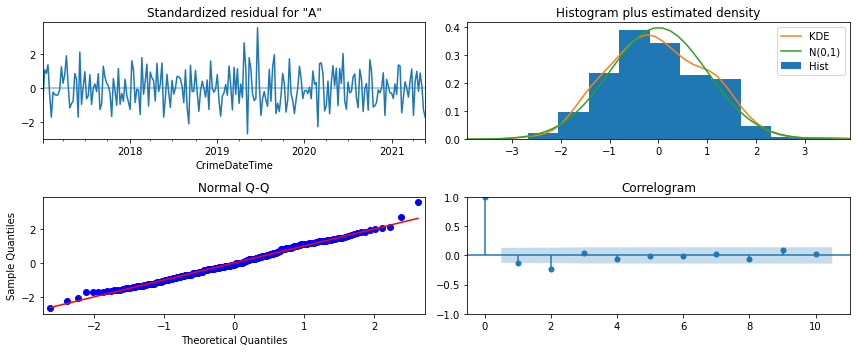

In [40]:
## Fit an AR model (using ARIMA with order (1,0,0))
model = tsa.arima.ARIMA(ts_diff, order=(1,0,0)).fit()
## Display mode. summary and plot diagnostics
display(model.summary())
model.plot_diagnostics();
plt.tight_layout()

In [41]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics();
    plt.tight_layout()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  229
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -974.318
Date:                Mon, 14 Jun 2021   AIC                           1954.635
Time:                        13:48:52   BIC                           1964.936
Sample:                    01-08-2017   HQIC                          1958.791
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1006      0.781     -0.129      0.898      -1.632       1.431
ar.L1         -0.4746      0.059     -8.060      0.000      -0.590      -0.359
sigma2       290.1657     27.956     10.379      0.000     235.374     344.958
===================================================================================
Ljung-Box (L1) (Q):                   4.12   Jarque-Bera (JB):                 1.94
Prob(Q):                              0.04   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                             0.22
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

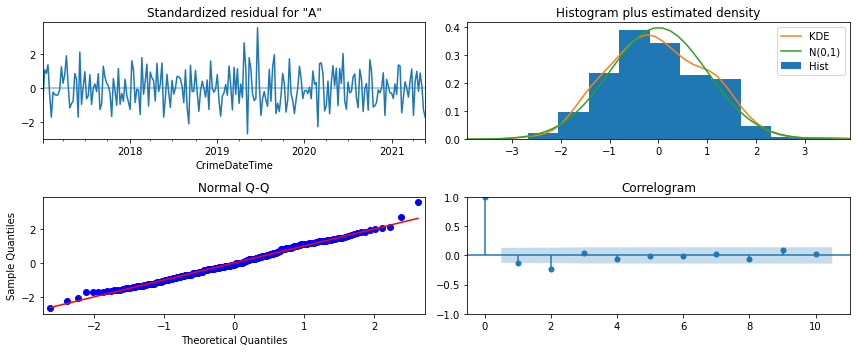

In [42]:
## Repeat model and diagnose
ar1_model = tsa.arima.ARIMA(ts_diff, order=(1,0,0)).fit()
diagnose_model(ar1_model)

### The  Moving Average Model




The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

In words, the mathematical idea is the following:

$$ \text{Today = Mean + Noise + Slope} \times \text{yesterday's noise} $$

Or, mathematically:
$$\large Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

Some notes based on this formula:
- If the slope is 0, the time series is a white noise model with mean $\mu$
- If the slope is not 0, the time series is autocorrelated and depends on the previous white noise process
- Bigger slope means bigger autocorrelation
- When there is a negative slope, the time series follow an oscillatory process


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  229
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -961.298
Date:                Mon, 14 Jun 2021   AIC                           1928.596
Time:                        13:48:52   BIC                           1938.898
Sample:                    01-08-2017   HQIC                          1932.752
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0767      0.382     -0.201      0.841      -0.825       0.671
ma.L1         -0.6595      0.054    -12.291      0.000      -0.765      -0.554
sigma2       258.5887     24.780     10.435      0.000     210.021     307.156
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 6.61
Prob(Q):                              0.82   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.41
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

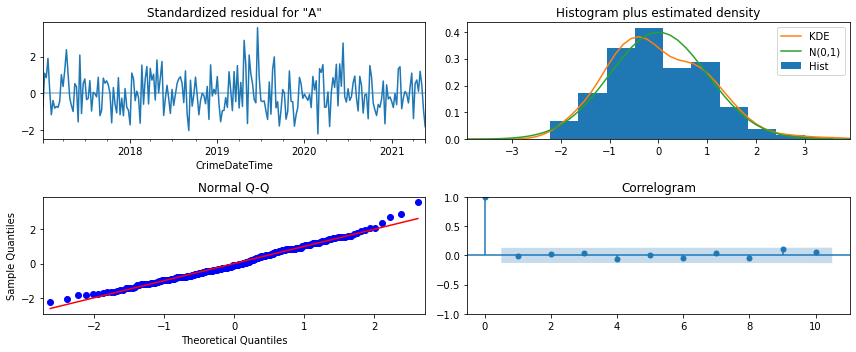

In [43]:
## Fit a MA 1 ARIMA(0,0,1)
ma_model = tsa.arima.ARIMA(ts_diff, order=(0,0,1)).fit()
diagnose_model(ma_model)

### Which is performing better? (Use AIC)

In [44]:
## can compare via the aic
print(f'AR1 Model aic = {ar1_model.aic:.3f}')
print(f'MA1 Model aic = {ma_model.aic:.3f}')

AR1 Model aic = 1954.635
MA1 Model aic = 1928.596


### Higher-order AR and MA models


- We are not limited to using just one time-step in our models. 
- The number of time steps used is called the **order** of the model.

#### First Order AR/MA Models:

- AR: $$Y_t = \mu + \phi * Y_{t-1}+\epsilon_t$$
- MA: $$Y_t = \mu +\epsilon_t + \theta * \epsilon_{t-1}$$

#### Second-Order AR/MA Models

- AR(2): $$Y_t = \mu + \phi_1 * Y_{t-1}+\phi_2 * Y_{t-2}+\epsilon_t$$
- MA(2): $$Y_t = \mu +\epsilon_t + \theta_1 * \epsilon_{t-1}+ \theta_2 * \epsilon_{t-2}$$



#### Number of AR (Auto-Regressive) terms (`p`): 

- `p` is the auto-regressive part of the model. It indicates how many AR coefficients should be included based on `p` # of timesteps/lags.
    -  For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q): 

- `q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past.
    -  For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

### Create a New  AR/MA model (depending on AIC of previous models) using a higher order

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  229
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -961.256
Date:                Mon, 14 Jun 2021   AIC                           1930.512
Time:                        13:48:53   BIC                           1944.247
Sample:                    01-08-2017   HQIC                          1936.053
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0762      0.392     -0.194      0.846      -0.844       0.692
ma.L1         -0.6718      0.065    -10.273      0.000      -0.800      -0.544
ma.L2          0.0190      0.066      0.287      0.774      -0.111       0.149
sigma2       258.4880     25.361     10.193      0.000     208.782     308.194
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.25
Prob(Q):                              0.97   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.40
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

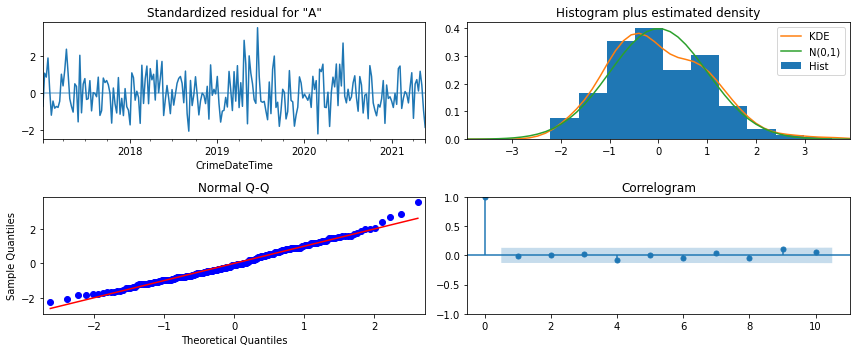

In [45]:
## Repeat model and diagnose
ma_model = tsa.arima.ARIMA(ts_diff, order=(0,0,2)).fit()
diagnose_model(ma_model)

#### Q: Did the model improve? What if we weren't limited to just AR or just MA?...

## ARMA & ARIMA Models

- We can combine BOTH an AR and MA model into one using an using an **AutoregRessive Moving Average** model (ARMA model).
    - We need to determine best number of p's and q's to use. 
- In actuality, we will go straight to using a slightly more advanced version of ARMA, which will actually difference our time series for us, allowing us to use the raw original ts for training. 
    

###  ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.


>- **An ARIMA is specified with (`p`,`d`,`q`)**
    - Number of AR (Auto-Regressive) terms (p)
    - Number of Differences (`d`):
        - `d` is the **Integrated** component of an ARIMA model. The number of lag values to subtract from the current observation (aka differencing). 
    - Number of MA (Moving Average) terms ($q$)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  229
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -961.255
Date:                Mon, 14 Jun 2021   AIC                           1930.509
Time:                        13:48:54   BIC                           1944.244
Sample:                    01-08-2017   HQIC                          1936.050
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0765      0.392     -0.195      0.845      -0.845       0.692
ar.L1         -0.0299      0.101     -0.297      0.767      -0.227       0.167
ma.L1         -0.6424      0.084     -7.635      0.000      -0.807      -0.477
sigma2       258.4864     25.327     10.206      0.000     208.845     308.127
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.24
Prob(Q):                              0.98   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.40
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

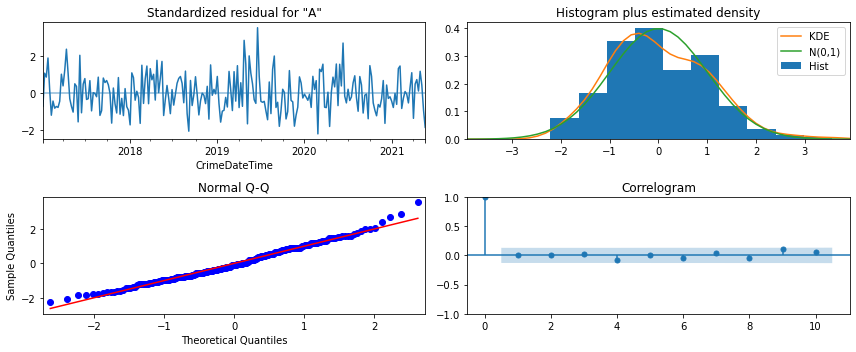

In [46]:
## Make an ARMA model with p=1, q=1
arma_model = tsa.arima.ARIMA(ts_diff, order=(1,0,1)).fit()
diagnose_model(arma_model)

## Determining the model and order to use via PACF/ACF _(if you can)_

- I've heard many different rules of thumb on how to use the PACF/ACF plots from earlier to determine whether to use AR/MA and how many p/q's to use. 
    - In my experience, it is rarely easy to see an obvious answer from these plots and it is better to use a gridsearch to determine the best performing model.
    - I have also heard competing answers on whether you should use the PACF/ACF for the original time series of the differenced time series.
    
- That all being said...

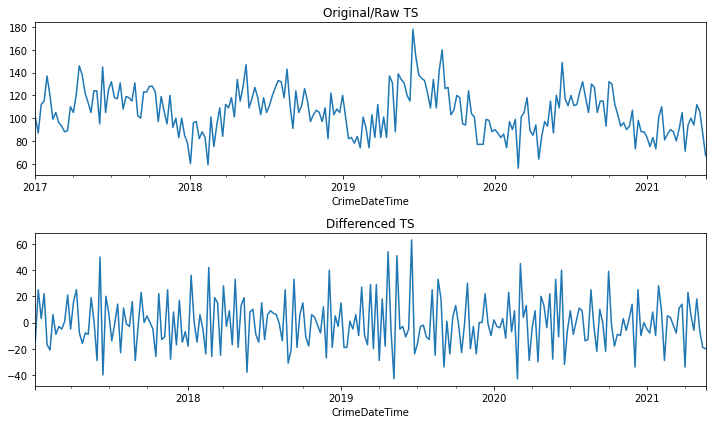

In [47]:
## PLotting the original vs differenced timeseires
fig,axes = plt.subplots(nrows=2, figsize=(10,6))
ts.plot(ax=axes[0],title='Original/Raw TS')
ts_diff.plot(ax=axes[1],title='Differenced TS')
plt.tight_layout()

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

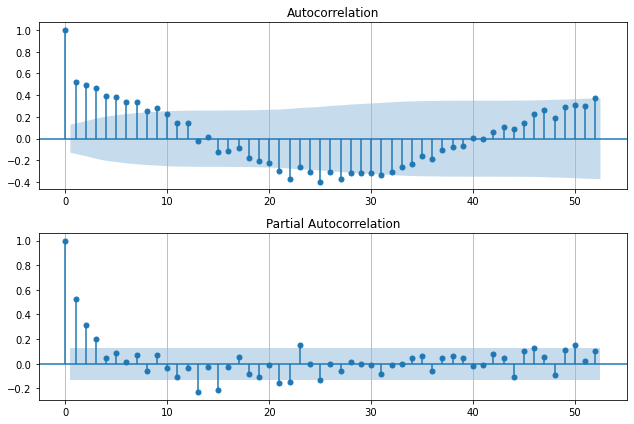

In [48]:
## Plot raw time series PACF
plot_acf_pacf(ts)

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

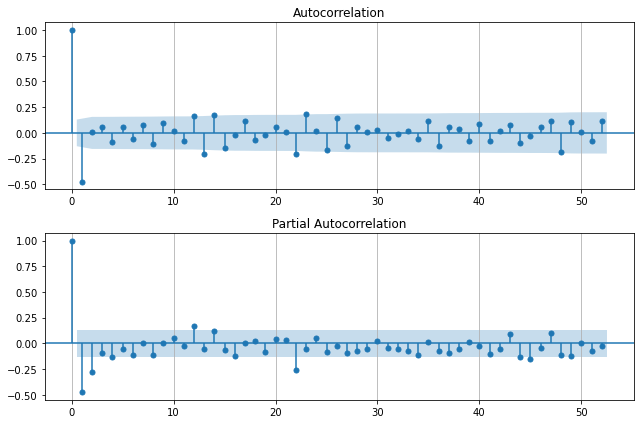

In [49]:
## Plotn differenced time sereis pacf
plot_acf_pacf(ts_diff)

#### Determining AR(p) and MA(q) using PACF [FROM  CANVAS]

- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately delcine to minimal/no correction.
    - PACF would show strong relationship to the lag and tailing off to no correlation afterwards.
   
- Notation is generally ARMA(p,q)
- Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$

| Param| AR(p)   |   MA(q)  | ARMA(p,q)|
|------|------|------|------|
|   ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|   PACF | Cuts off after lag p  |   Tails off  |  Tails off  |
  parameters and use for prediction

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

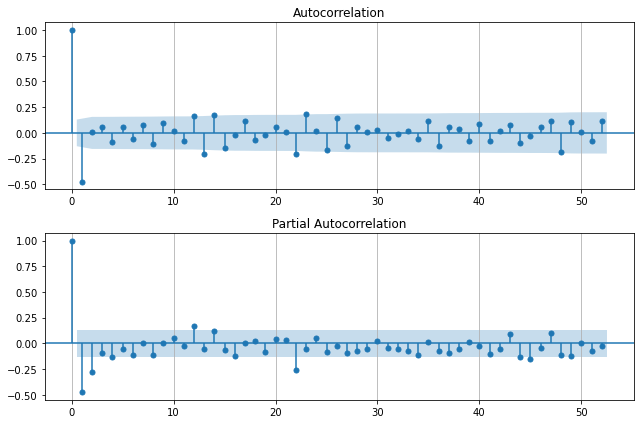

In [50]:
## Visualize either figure to look for the above
# p=2,3
plot_acf_pacf(ts_diff)

####  Determining AR(p) and MA(q) using PACF [INFO FROM UDEMY]

- **USE ACF TO JUDGE IF MA OR AR COMPONENTS:**
    - If lag 1 is positive: AR
    - If lag 1 is negatige: MA
    
- **PACF is best for picking AR (p)**
- **ACF is best for picking MA(q)**
    - If sharp drop off at lag of k (k= point on x axis) means use an AR model of order k.
    - If slow gradual decline: use MA
    
    

#### Determining AR(p) and MA(q) using PACF [Centra Lecturer]

<img src="https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/ds-time_series-main/img/armaguidelines.png" width=90%>

### Determining `p`,`d`,`q` programmatically

In [51]:
### From SARIMA Models Lab
import itertools
from tqdm.notebook import trange
# Define the p, d and q parameters to take any value between 0 and 2
ps = list(range(0,4))
ds = list(range(0,2))
qs = list(range(0,3))

# Generate all different combinations of p, q and q triplets
pdq_list = list(itertools.product(ps,ds, qs))
pdq_list

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2)]

In [52]:
## Loop through pdq_list, make an ARIMA model
# save p,d,q and aic to a model_aic list
model_aics= [['p','d','q','aic']]

## Make Results into a df and sort by aic
for i in trange(len(pdq_list)):
    p,d,q = pdq_list[i]
    model = tsa.arima.ARIMA(ts,order=(p,d,q),enforce_invertibility=False).fit()
    model_aics.append([p,d,q,model.aic])
    print(f'For ({p},{d},{q}), aic = {model.aic:.3f}')

results = pd.DataFrame(model_aics[1:],columns=model_aics[0]).sort_values('aic')
results

For (0,0,0), aic = 2033.479
For (0,0,1), aic = 1990.869
For (0,0,2), aic = 1972.352
For (0,1,0), aic = 2008.961
For (0,1,1), aic = 1926.641
For (0,1,2), aic = 1928.555
For (1,0,0), aic = 1960.941
For (1,0,1), aic = 1930.210
For (1,0,2), aic = 1931.650
For (1,1,0), aic = 1952.651
For (1,1,1), aic = 1928.552
For (1,1,2), aic = 1930.353
For (2,0,0), aic = 1939.345
For (2,0,1), aic = 1931.686
For (2,0,2), aic = 1933.632
For (2,1,0), aic = 1935.954
For (2,1,1), aic = 1930.536
For (2,1,2), aic = 1931.702
For (3,0,0), aic = 1932.458
For (3,0,1), aic = 1933.528
For (3,0,2), aic = 1935.602
For (3,1,0), aic = 1935.784
For (3,1,1), aic = 1931.988
For (3,1,2), aic = 1932.765



p  d  q       aic
4   0  1  1  1926.641
10  1  1  1  1928.552
5   0  1  2  1928.555
7   1  0  1  1930.210
11  1  1  2  1930.353
16  2  1  1  1930.536
8   1  0  2  1931.650
13  2  0  1  1931.686
17  2  1  2  1931.702
22  3  1  1  1931.988
18  3  0  0  1932.458
23  3  1  2  1932.765
19  3  0  1  1933.528
14  2  0  2  1933.632
20  3  0  2  1935.602
21  3  1  0  1935.784
15  2  1  0  1935.954
12  2  0  0  1939.345
9   1  1  0  1952.651
6   1  0  0  1960.941
2   0  0  2  1972.352
1   0  0  1  1990.869
3   0  1  0  2008.961
0   0  0  0  2033.479

In [53]:
## Save best_params as a dict
best_params = results.iloc[0][['p','d','q']].to_dict()
best_params

{'p': 0.0, 'd': 1.0, 'q': 1.0}

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  230
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -961.321
Date:                Mon, 14 Jun 2021   AIC                           1926.641
Time:                        13:49:00   BIC                           1933.509
Sample:                    01-01-2017   HQIC                          1929.412
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6592      0.054    -12.278      0.000      -0.764      -0.554
sigma2       258.6443     23.907     10.819      0.000     211.787     305.501
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 6.61
Prob(Q):                              0.82   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.41
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

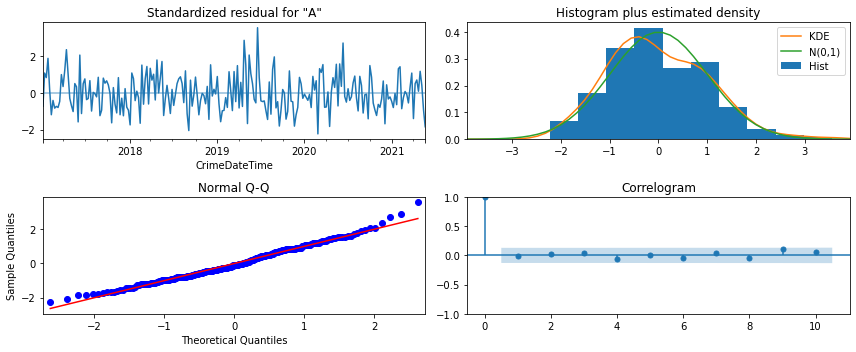

In [54]:
## Make a best_model using the best_params from our loop
best_model =tsa.arima.ARIMA(ts, order= tuple(best_params.values())).fit()
diagnose_model(best_model)

# Forecasts vs Predictions (`statsmodels`)

## Forecasts

`model.forecast()`/`model.get_forecast()` are designed for predictions **after the training data**. It needs the # of time steps in the future to forecast. 
- `model.forecast()` will return JUST the mean value for the forecast.


- `forecast = model.get_forecast()` will return a special `PredictionResultsWrapper` object that contains:
    - `forecast.conf_int()`: the lower and upper limits of the confidence indterval (as a dataframe).
        ` forecast.predicted_mean`: the mean value of the forecast (returned as a series)

In [55]:
## forecast
best_model.forecast(steps=12)

2021-05-30 00:00:00+00:00    86.574
2021-06-06 00:00:00+00:00    86.574
2021-06-13 00:00:00+00:00    86.574
2021-06-20 00:00:00+00:00    86.574
2021-06-27 00:00:00+00:00    86.574
2021-07-04 00:00:00+00:00    86.574
2021-07-11 00:00:00+00:00    86.574
2021-07-18 00:00:00+00:00    86.574
2021-07-25 00:00:00+00:00    86.574
2021-08-01 00:00:00+00:00    86.574
2021-08-08 00:00:00+00:00    86.574
2021-08-15 00:00:00+00:00    86.574
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [56]:
## get_forecast
forecast = best_model.get_forecast(steps=12)
forecast

In [57]:
## Check out the pred's predicted_mean
forecast.predicted_mean

2021-05-30 00:00:00+00:00    86.574
2021-06-06 00:00:00+00:00    86.574
2021-06-13 00:00:00+00:00    86.574
2021-06-20 00:00:00+00:00    86.574
2021-06-27 00:00:00+00:00    86.574
2021-07-04 00:00:00+00:00    86.574
2021-07-11 00:00:00+00:00    86.574
2021-07-18 00:00:00+00:00    86.574
2021-07-25 00:00:00+00:00    86.574
2021-08-01 00:00:00+00:00    86.574
2021-08-08 00:00:00+00:00    86.574
2021-08-15 00:00:00+00:00    86.574
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [58]:
## check out pred's conf_int
forecast.conf_int()

lower AGG. ASSAULT  upper AGG. ASSAULT
2021-05-30 00:00:00+00:00              55.053             118.095
2021-06-06 00:00:00+00:00              53.273             119.875
2021-06-13 00:00:00+00:00              51.584             121.564
2021-06-20 00:00:00+00:00              49.972             123.176
2021-06-27 00:00:00+00:00              48.429             124.719
2021-07-04 00:00:00+00:00              46.945             126.203
2021-07-11 00:00:00+00:00              45.515             127.633
2021-07-18 00:00:00+00:00              44.134             129.014
2021-07-25 00:00:00+00:00              42.795             130.353
2021-08-01 00:00:00+00:00              41.497             131.651
2021-08-08 00:00:00+00:00              40.235             132.913
2021-08-15 00:00:00+00:00              39.006             134.142

In [59]:
## Get confidence intervals and predicted mean
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['forecast'] = forecast.predicted_mean
forecast_df

Lower CI  Upper CI  forecast
2021-05-30 00:00:00+00:00    55.053   118.095    86.574
2021-06-06 00:00:00+00:00    53.273   119.875    86.574
2021-06-13 00:00:00+00:00    51.584   121.564    86.574
2021-06-20 00:00:00+00:00    49.972   123.176    86.574
2021-06-27 00:00:00+00:00    48.429   124.719    86.574
2021-07-04 00:00:00+00:00    46.945   126.203    86.574
2021-07-11 00:00:00+00:00    45.515   127.633    86.574
2021-07-18 00:00:00+00:00    44.134   129.014    86.574
2021-07-25 00:00:00+00:00    42.795   130.353    86.574
2021-08-01 00:00:00+00:00    41.497   131.651    86.574
2021-08-08 00:00:00+00:00    40.235   132.913    86.574
2021-08-15 00:00:00+00:00    39.006   134.142    86.574

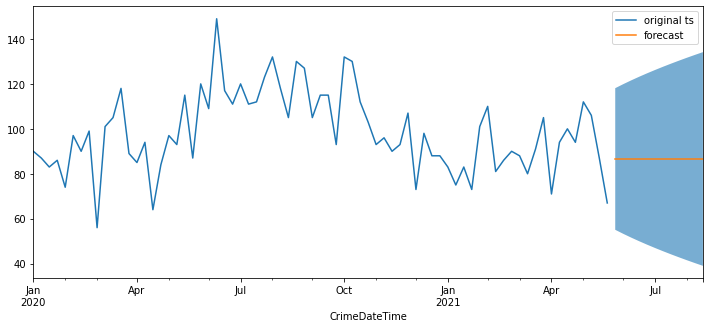

In [60]:
### PLot forecast with confidence intervals
fig,ax = plt.subplots()
ts.loc['2020':].plot(ax=ax,label='original ts')
forecast_df['forecast'].plot(ax=ax)


ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'],
                forecast_df['Upper CI'],alpha=0.6)

ax.legend()

### Forecasting Functions

In [61]:
def get_df_from_pred(forecast_or_pred,forecast_label='Forecast'):
    """Takes a PredictionResultsWrapper from statsmodels
    extracts the confidence intervals and predicted mean and returns in a df"""
    forecast_df = forecast_or_pred.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df[forecast_label] = forecast_or_pred.predicted_mean
    return forecast_df

def plot_forecast_from_df(forecast_df,ts_diff=None,orig_label='True Data',
                          forecast_label='Forecast',
                          last_n_lags=52,figsize=(10,4)):
    """Takes a forecast_df from get_df_from_pred and optionally 
    the training/original time series.
    
    Plots the original ts, the predicted mean and the 
    confidence invtervals (using fill between)"""
    fig,ax = plt.subplots(figsize=figsize)

    if ts_diff is not None:
        ts_diff.iloc[-last_n_lags:].plot(label='True Data')
        
   
    forecast_df['Forecast'].plot(ax=ax,label=forecast_label)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'],color='g',alpha=0.3)
    ax.legend()
    ax.set(title=f'Forecasted {ts_diff.name}')
    return fig,ax

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  230
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -961.321
Date:                Mon, 14 Jun 2021   AIC                           1926.641
Time:                        13:49:01   BIC                           1933.509
Sample:                    01-01-2017   HQIC                          1929.412
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6592      0.054    -12.278      0.000      -0.764      -0.554
sigma2       258.6443     23.907     10.819      0.000     211.787     305.501
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 6.61
Prob(Q):                              0.82   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.41
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted AGG. ASSAULT'}, xlabel='CrimeDateTime'>)

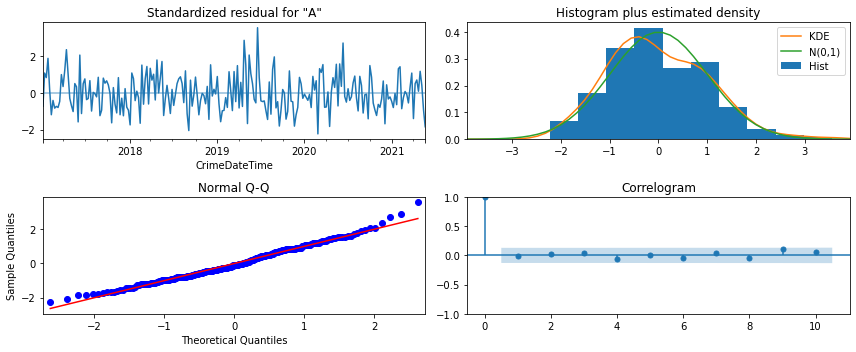

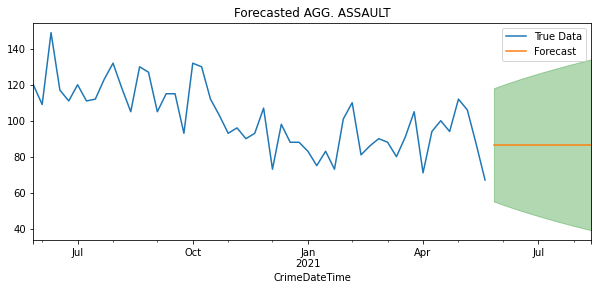

In [62]:
## Combine getting a new model, forecast_df, and plotting
best_model =tsa.arima.ARIMA(ts, order= tuple(best_params.values())).fit()
diagnose_model(best_model)


forecast = best_model.get_forecast(steps=12)
forecast_df = get_df_from_pred(forecast)
plot_forecast_from_df(forecast_df, ts)

## Predictions

- `.predict/get_prediction` return a prediction for times within the original training period. (can also get into future)
    - Instead of the number of timesteps, predict needs the start and end dates for the forecast. `start=None, end=None,`
        - Note: if no times are provided, it will produce predictions for the entire training time series.

    
- Dynamic vs One-Step-Ahead Predictions:
    - Additionally, since predictions are during the same times as the actual data, we have the option to get dynamic/non-dynamic forecasts.
    - `dynamic=True`: will behave like a forecast where each step in time is predicted based on the previously predicted time. 
    - `dynamic=False`: will ONLY predict one step ahead in time, so the predictions for all data points were ONLY guessing 1 step ahead for each point. 

In [63]:
## Get one-step-ahead preditions for the last 12 weeks of the dataset
one_step_ahead_mean = model.predict(start=-12, end=-1,dynamic=False)
one_step_ahead_mean

CrimeDateTime
2021-03-07 00:00:00+00:00     87.915
2021-03-14 00:00:00+00:00     89.286
2021-03-21 00:00:00+00:00     85.563
2021-03-28 00:00:00+00:00     87.489
2021-04-04 00:00:00+00:00     92.952
2021-04-11 00:00:00+00:00     87.110
2021-04-18 00:00:00+00:00     88.527
2021-04-25 00:00:00+00:00     90.779
2021-05-02 00:00:00+00:00     95.076
2021-05-09 00:00:00+00:00     98.587
2021-05-16 00:00:00+00:00    102.274
2021-05-23 00:00:00+00:00     97.386
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [64]:
## get_prediction from model
one_step_ahead_prediction = model.get_prediction(start=-12,end=-1,dynamic=False)
one_step_ahead_prediction

In [65]:
## conf_int
one_step_ahead_prediction.conf_int()

lower AGG. ASSAULT  upper AGG. ASSAULT
CrimeDateTime                                                    
2021-03-07 00:00:00+00:00              56.515             119.315
2021-03-14 00:00:00+00:00              57.886             120.686
2021-03-21 00:00:00+00:00              54.163             116.963
2021-03-28 00:00:00+00:00              56.089             118.889
2021-04-04 00:00:00+00:00              61.552             124.352
2021-04-11 00:00:00+00:00              55.710             118.510
2021-04-18 00:00:00+00:00              57.127             119.927
2021-04-25 00:00:00+00:00              59.379             122.179
2021-05-02 00:00:00+00:00              63.676             126.476
2021-05-09 00:00:00+00:00              67.187             129.987
2021-05-16 00:00:00+00:00              70.874             133.674
2021-05-23 00:00:00+00:00              65.986             128.787

In [66]:
## Also contains the .predicted mean
one_step_ahead_prediction.predicted_mean

CrimeDateTime
2021-03-07 00:00:00+00:00     87.915
2021-03-14 00:00:00+00:00     89.286
2021-03-21 00:00:00+00:00     85.563
2021-03-28 00:00:00+00:00     87.489
2021-04-04 00:00:00+00:00     92.952
2021-04-11 00:00:00+00:00     87.110
2021-04-18 00:00:00+00:00     88.527
2021-04-25 00:00:00+00:00     90.779
2021-05-02 00:00:00+00:00     95.076
2021-05-09 00:00:00+00:00     98.587
2021-05-16 00:00:00+00:00    102.274
2021-05-23 00:00:00+00:00     97.386
Freq: W-SUN, Name: predicted_mean, dtype: float64

Text(0.5, 1.02, 'One Step Ahead')

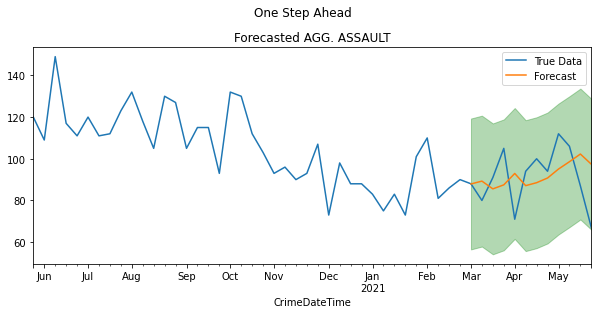

In [67]:
## plot one step ahead forecasat
one_step_ahead_prediction = model.get_prediction(start=-12,end=-1,dynamic=False)
forecast_df = get_df_from_pred(one_step_ahead_prediction)
f,ax = plot_forecast_from_df(forecast_df,ts)
f.suptitle('One Step Ahead',y=1.02)

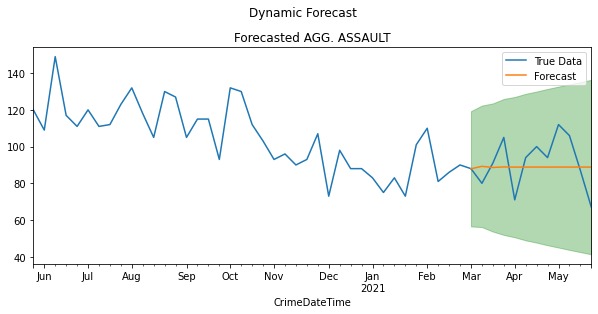

In [68]:
## Using the above functions, get a dyanmic prediction and plot
one_step_ahead_prediction = model.get_prediction(start=-12,end=-1,dynamic=True)
forecast_df = get_df_from_pred(one_step_ahead_prediction)
f,ax = plot_forecast_from_df(forecast_df,ts)
f.suptitle('Dynamic Forecast',y=1.02);

> #### Q: What do we notice about the dynamic vs non-dynamic predictions?


___

# SARIMA & SARIMAX MODELS:


### SARIMA Models

- Seasonal ARIMA Models add a longer/larger seasonal ARIMA model combined with a non-seasonal ARIMA model.

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

- Note: we will use the `SARIMAX` model from statsmodels, which allows for another variable (`X` aka exog) to be used in the modeling.

In [69]:
## make sure have pdfq=best params
pdq = tuple(best_params.values())
pdq

(0.0, 1.0, 1.0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  230
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -961.321
Date:                Mon, 14 Jun 2021   AIC                           1926.641
Time:                        13:49:03   BIC                           1933.509
Sample:                    01-01-2017   HQIC                          1929.412
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6592      0.054    -12.279      0.000      -0.764      -0.554
sigma2       258.6277     23.904     10.819      0.000     211.777     305.479
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 6.61
Prob(Q):                              0.82   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.41
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

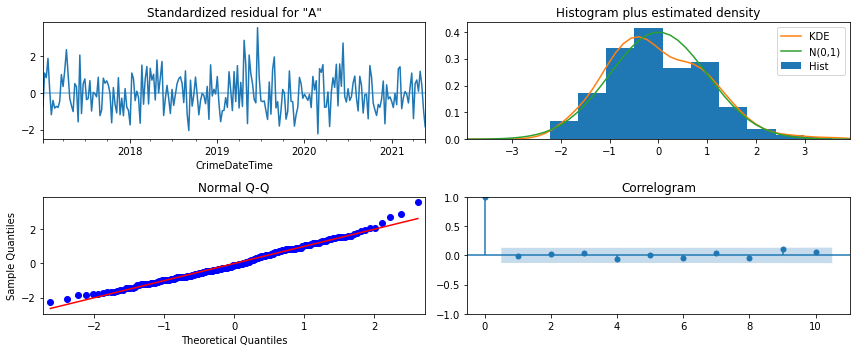

In [70]:
## Make a SARIMAZ model using best pdq from ARIMA.
sarimax_model = tsa.SARIMAX(ts,order=pdq,enforce_invertibility=False).fit()
diagnose_model(sarimax_model)

> **Q: Does the seasonal ARIMA with seasonal order= (0,0,0,0)look familiar?**

In [71]:
## Copy the above code and replace the SARIMAX with .arima.ARIMA


## Selecting Seasonal Orders

- Figuring out the seasonal component can be tricky. 
- For one, we have to know the value for $s$, which is how many time steps should be considered a season. 
    - Use seasonal decompose to look for potential seasonality/$s$

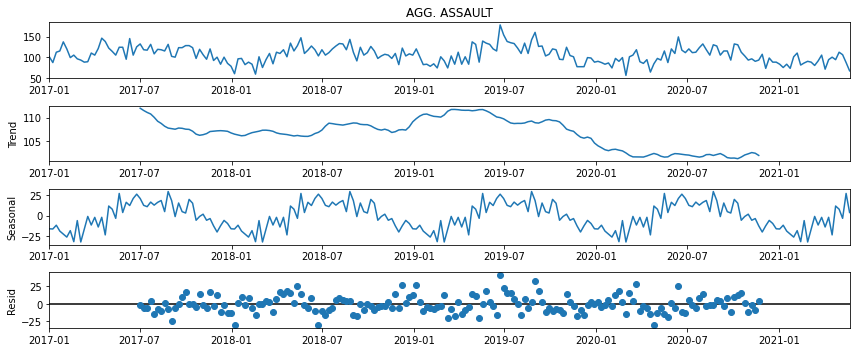

In [72]:
## use seasonal decompose and plot to look for s
decomp = tsa.seasonal_decompose(ts)
decomp.plot();

- Using the value for $m$ inferred above, try making a SARIMAX model 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       AGG. ASSAULT   No. Observations:                  230
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 52)   Log Likelihood                -959.206
Date:                            Mon, 14 Jun 2021   AIC                           1926.413
Time:                                    13:49:08   BIC                           1940.147
Sample:                                01-01-2017   HQIC                          1931.954
                                     - 05-23-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6792      0.053    -12.745      0.000      -0.784      -0.575
ar.S.L52       0.3310      0.632      0.524      0.600      -0.907       1.569
ma.S.L52      -0.1865      0.650     -0.287      0.774      -1.461       1.088
sigma2       252.4693     22.804     11.071      0.000     207.773     297.165
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.48
Prob(Q):                              0.95   Prob(JB):                         0.01
Heteroskedasticity (H):               0.92   Skew:                             0.46
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

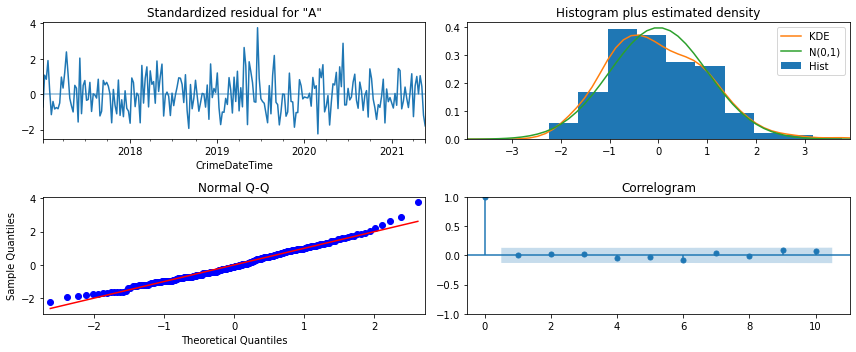

In [73]:
sarimax_model = tsa.SARIMAX(ts,order=pdq,
                            seasonal_order=(1,0,1,52), 
                            enforce_invertibility=False).fit()
diagnose_model(sarimax_model)

In [74]:
## using all of our functions to train our model, get and plot forecast


### Functionize Entire  process

In [75]:
def evaluate_model():
    pass

In [76]:
## Test functionizing process


## `pmdarima.auto_arima`

- While we could construct another loop/grid and add a seasonal PDQ list to iterate through (see the SARIMAX Lab for example).
- There is a package called `pmdarima` which makes an auto-arima model for python (like there is for R)
    - http://alkaline-ml.com/pmdarima/

In [77]:
# !pip install -U pmdarima
import pmdarima as pmd
# help(pmd.auto_arima)

<AxesSubplot:xlabel='CrimeDateTime'>

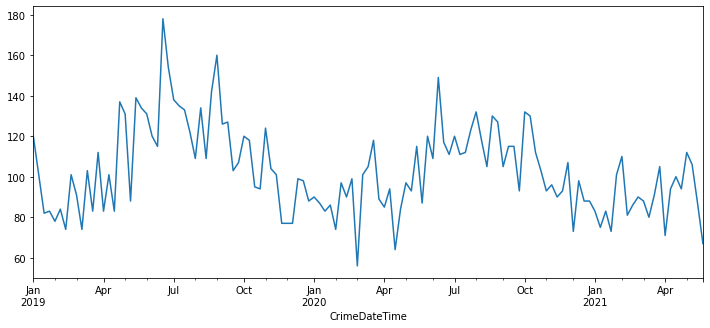

In [78]:
## Cut down ts to 2019-present (for time sake)
ts = ts.loc['2019':]
ts.plot()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -527.228
Date:                Mon, 14 Jun 2021   AIC                           1058.456
Time:                        13:49:17   BIC                           1064.097
Sample:                             0   HQIC                          1060.748
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6613      0.079     -8.389      0.000      -0.816      -0.507
sigma2       287.4725     34.063      8.439      0.000     220.709     354.236
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.17
Prob(Q):                              0.83   Prob(JB):                         0.02
Heteroskedasticity (H):               0.49   Skew:                             0.59
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

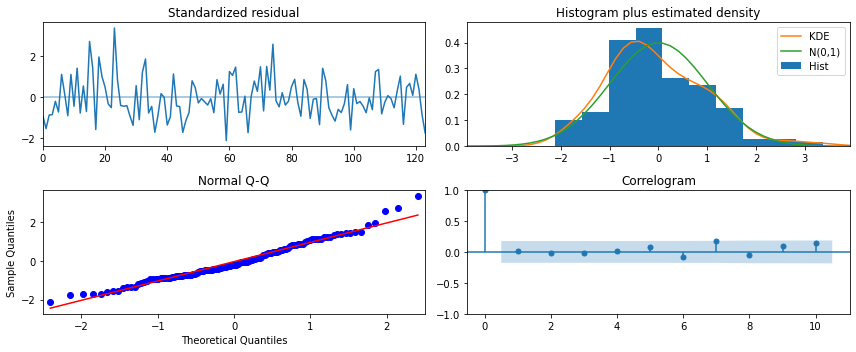

In [79]:
## Use auto_arima 
auto_model = pmd.auto_arima(ts,start_p=0,start_q=0,d=1,
                            max_p=4,max_q=4,
                            max_P=3,max_Q=3,
                            start_P=0,start_Q=0,
                            m=52,
                            verbose=2)
diagnose_model(auto_model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  125
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -527.228
Date:                Mon, 14 Jun 2021   AIC                           1058.456
Time:                        13:49:17   BIC                           1064.097
Sample:                    01-06-2019   HQIC                          1060.748
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6613      0.079     -8.388      0.000      -0.816      -0.507
sigma2       287.4855     34.067      8.439      0.000     220.716     354.255
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.17
Prob(Q):                              0.83   Prob(JB):                         0.02
Heteroskedasticity (H):               0.49   Skew:                             0.59
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

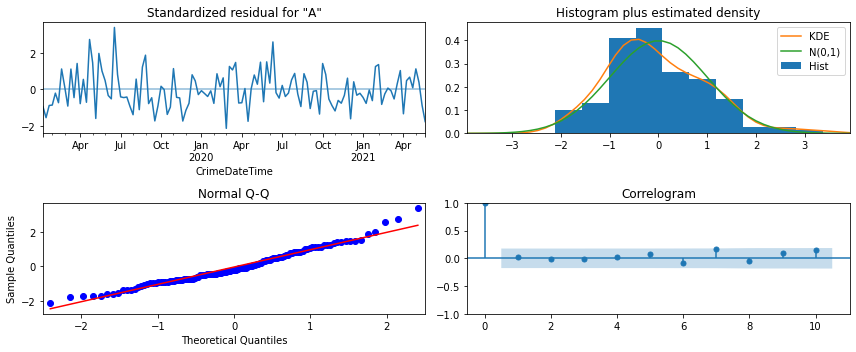

In [80]:
## Make a sarimax using params from auto_model
model = tsa.SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='W').fit()

diagnose_model(model)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AGG. ASSAULT   No. Observations:                  125
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -527.228
Date:                Mon, 14 Jun 2021   AIC                           1058.456
Time:                        13:49:18   BIC                           1064.097
Sample:                    01-06-2019   HQIC                          1060.748
                         - 05-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6613      0.079     -8.388      0.000      -0.816      -0.507
sigma2       287.4855     34.067      8.439      0.000     220.716     354.255
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 8.17
Prob(Q):                              0.83   Prob(JB):                         0.02
Heteroskedasticity (H):               0.49   Skew:                             0.59
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted AGG. ASSAULT'}, xlabel='CrimeDateTime'>)

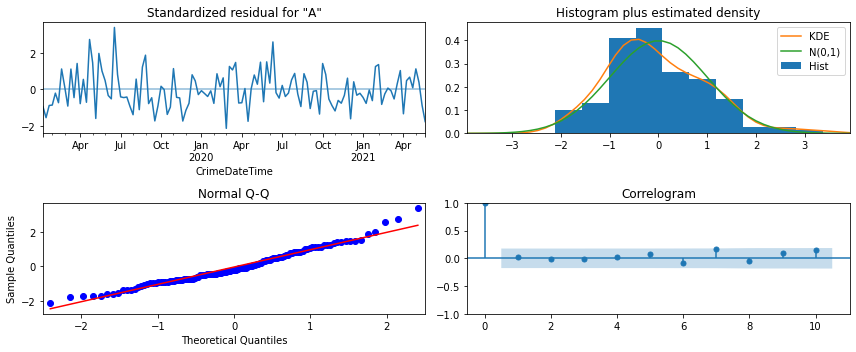

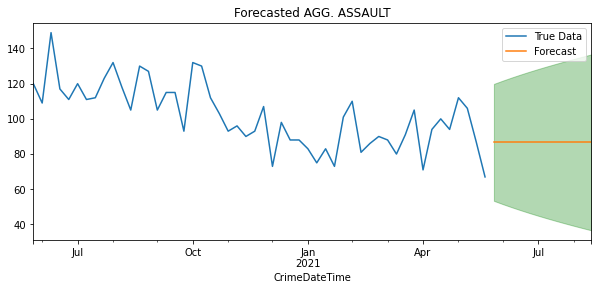

In [81]:
diagnose_model(model)
forecast = model.get_forecast(steps=12)
forecast_df = get_df_from_pred(forecast)
plot_forecast_from_df(forecast_df,ts)

<a id='06-14-21_office_hours'></a>

# **📖 06/14/21 Office Hours:** Train-test-split and model validation


## Activity: Modeling with Crimes

- Using the examples we've made in this notebook:
    - Select a crime from our original df.
    - Create a train/test/ split.
    - Train/tune a model using the training data. 
    - Get the model's forecast for the test data's period. 
    - Plot the model's forecast vs actual test data.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from random import gauss

pd.set_option('precision',3)
plt.rcParams['figure.figsize'] = [12,5]

## Plotly Express
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Statmodels time series analysis 
import statsmodels.tsa.api as tsa

# !pip install -U pmdarima
import pmdarima as pmd
# help(pmd.auto_arima)

In [91]:
# pwd

### Functions from Class

In [84]:
## appending folder with functions
import sys
sys.path.append("../../topic_38_time_series_models/")

## Functions from Last Class 
%load_ext autoreload
%autoreload 2
import ts_functions as tsf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics();
    plt.tight_layout()
    
    
def plot_acf_pacf(ts,figsize=(9,6),lags=52,suptitle=None,sup_y = 1.01):
    """Plot pacf and acf using statsmodels"""
    fig,axes=plt.subplots(nrows=2,figsize=figsize)
    
    tsa.graphics.plot_acf(ts,ax=axes[0],lags=lags);
    tsa.graphics.plot_pacf(ts,ax=axes[1],lags=lags);
    
    ## Add grid
    [ax.grid(axis='x',which='both') for ax in axes]
    
    if suptitle is not None:
        fig.suptitle(suptitle,y=sup_y,fontweight='bold',fontsize=15)
        
    fig.tight_layout()
    return fig,ax
    

### Loading in Time Series

In [86]:
## Load in file and parse_dates, check index
file ="https://raw.githubusercontent.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/master/Phase_4/topic_37_intro_to_time_series/baltimore_crime_counts_2021.csv"
df = pd.read_csv(file,parse_dates=True, index_col='CrimeDateTime')
display(df.head(),df.index)

HOMICIDE  AGG. ASSAULT  COMMON ASSAULT  LARCENY  \
CrimeDateTime                                                                
2014-01-01 00:00:00+00:00         2            22              19       34   
2014-01-02 00:00:00+00:00         3             6              23       26   
2014-01-03 00:00:00+00:00         1            11              17       16   
2014-01-04 00:00:00+00:00         0            14              23       23   
2014-01-05 00:00:00+00:00         0             9              22       19   

                           AUTO THEFT  ROBBERY - CARJACKING  BURGLARY  \
CrimeDateTime                                                           
2014-01-01 00:00:00+00:00           9                   0.0        20   
2014-01-02 00:00:00+00:00           7                   1.0        28   
2014-01-03 00:00:00+00:00           3                   0.0        13   
2014-01-04 00:00:00+00:00          14                   0.0        20   
2014-01-05 00:00:00+00:00          11                   2.0        14   

                           LARCENY FROM AUTO  ROBBERY - COMMERCIAL  SHOOTING  \
CrimeDateTime                                                                  
2014-01-01 00:00:00+00:00                 15                     2         2   
2014-01-02 00:00:00+00:00                 10                     1         0   
2014-01-03 00:00:00+00:00                  6                     1         1   
2014-01-04 00:00:00+00:00                 15                     1         0   
2014-01-05 00:00:00+00:00                 13                     0         2   

                           ROBBERY - RESIDENCE  ROBBERY - STREET  ARSON  RAPE  
CrimeDateTime                                                                  
2014-01-01 00:00:00+00:00                  1.0               8.0    0.0   5.0  
2014-01-02 00:00:00+00:00                  1.0               4.0    0.0   0.0  
2014-01-03 00:00:00+00:00                  1.0               2.0    0.0   0.0  
2014-01-04 00:00:00+00:00                  1.0               7.0    0.0   0.0  
2014-01-05 00:00:00+00:00                  1.0              10.0    0.0   1.0

DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-02 00:00:00+00:00',
               '2014-01-03 00:00:00+00:00', '2014-01-04 00:00:00+00:00',
               '2014-01-05 00:00:00+00:00', '2014-01-06 00:00:00+00:00',
               '2014-01-07 00:00:00+00:00', '2014-01-08 00:00:00+00:00',
               '2014-01-09 00:00:00+00:00', '2014-01-10 00:00:00+00:00',
               ...
               '2021-05-13 00:00:00+00:00', '2021-05-14 00:00:00+00:00',
               '2021-05-15 00:00:00+00:00', '2021-05-16 00:00:00+00:00',
               '2021-05-17 00:00:00+00:00', '2021-05-18 00:00:00+00:00',
               '2021-05-19 00:00:00+00:00', '2021-05-20 00:00:00+00:00',
               '2021-05-21 00:00:00+00:00', '2021-05-22 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=2699, freq=None)

In [87]:
## resample.asfreq
dfw = df.resample('W').sum()#:]
dfw.index

DatetimeIndex(['2014-01-05 00:00:00+00:00', '2014-01-12 00:00:00+00:00',
               '2014-01-19 00:00:00+00:00', '2014-01-26 00:00:00+00:00',
               '2014-02-02 00:00:00+00:00', '2014-02-09 00:00:00+00:00',
               '2014-02-16 00:00:00+00:00', '2014-02-23 00:00:00+00:00',
               '2014-03-02 00:00:00+00:00', '2014-03-09 00:00:00+00:00',
               ...
               '2021-03-21 00:00:00+00:00', '2021-03-28 00:00:00+00:00',
               '2021-04-04 00:00:00+00:00', '2021-04-11 00:00:00+00:00',
               '2021-04-18 00:00:00+00:00', '2021-04-25 00:00:00+00:00',
               '2021-05-02 00:00:00+00:00', '2021-05-09 00:00:00+00:00',
               '2021-05-16 00:00:00+00:00', '2021-05-23 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='CrimeDateTime', length=386, freq='W-SUN')

In [88]:
## Get a list of crimes to remind ourselves what we have
dfw.sum().sort_values(ascending=False)

LARCENY                 74681.0
COMMON ASSAULT          57451.0
BURGLARY                46935.0
LARCENY FROM AUTO       43223.0
AGG. ASSAULT            38478.0
AUTO THEFT              29502.0
ROBBERY - STREET        23056.0
ROBBERY - COMMERCIAL     5872.0
SHOOTING                 4777.0
ROBBERY - RESIDENCE      3590.0
ROBBERY - CARJACKING     3128.0
HOMICIDE                 2311.0
RAPE                     2236.0
ARSON                    1409.0
dtype: float64

In [89]:
px.line(dfw,width=900)

<AxesSubplot:xlabel='CrimeDateTime'>

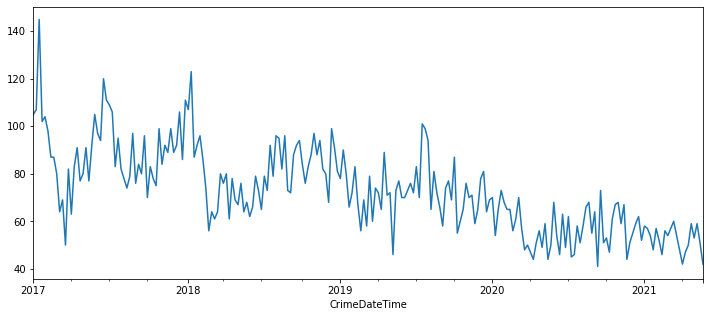

In [92]:
## save chosen ts as var
ts = dfw['AUTO THEFT'].loc['2017':].copy()
ts.plot()

### Train-Test-Split for Time Series

In [93]:
# get the tts_cutoff  (the # of timesteps/rows to split at)
tts_cutoff = round(ts.shape[0]*0.80)
tts_cutoff

184

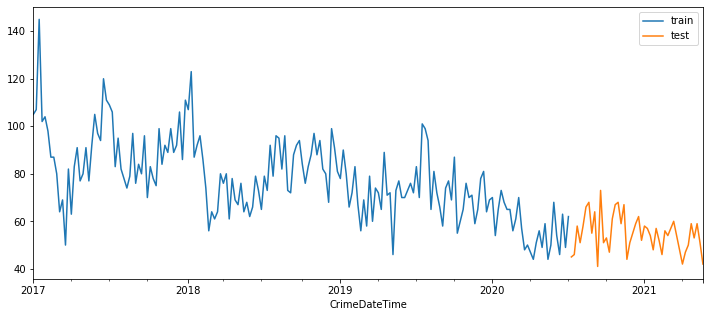

In [94]:
## Use the tts cutoff to do Train test split and plot
train = ts.iloc[:tts_cutoff]
test = ts.iloc[tts_cutoff:]

## Plot
ax = train.plot(label='train')
test.plot(label='test')
ax.legend()

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results          -3.999           2                     181   

                   p-value  p<.05  Stationary?  
AD Fuller Results    0.001   True         True

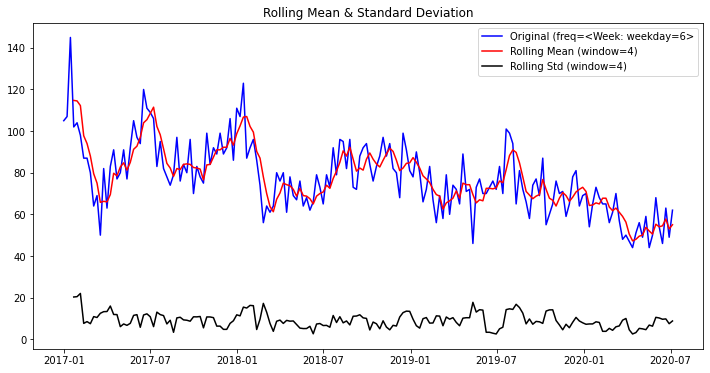

Test Statistic  #Lags Used  # of Observations Used  \
AD Fuller Results          -3.999           2                     181   

                   p-value  p<.05  Stationary?  
AD Fuller Results    0.001   True         True

In [95]:
## check staationarity 
tsf.stationarity_check(train, window=4)

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

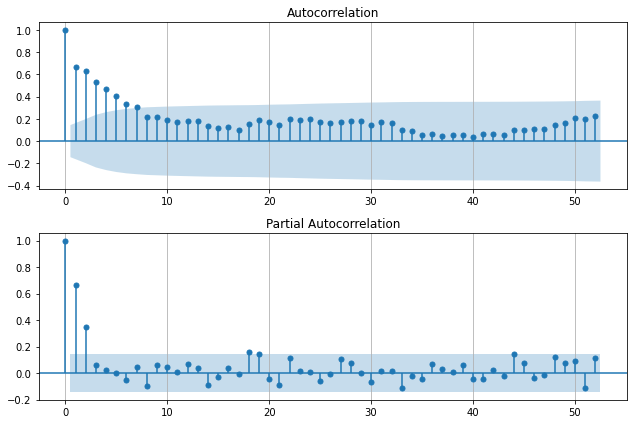

In [96]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train)

(<Figure size 648x432 with 2 Axes>, <AxesSubplot:xlabel='CrimeDateTime'>)

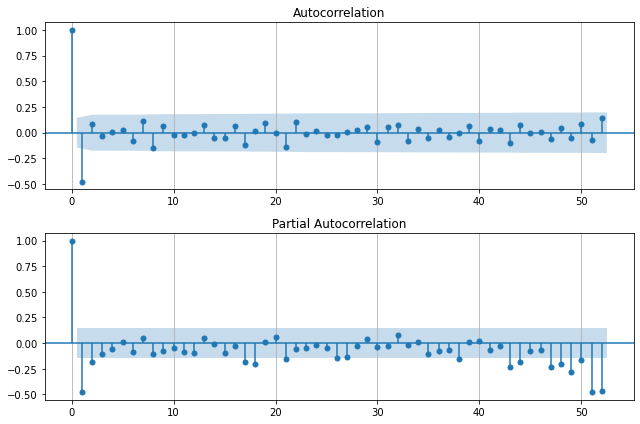

In [97]:
### Check PACF/ACF to infer p/q (if possible)
plot_acf_pacf(train.diff().dropna())

- Possible values:
    - p:
    - d:
    - q:

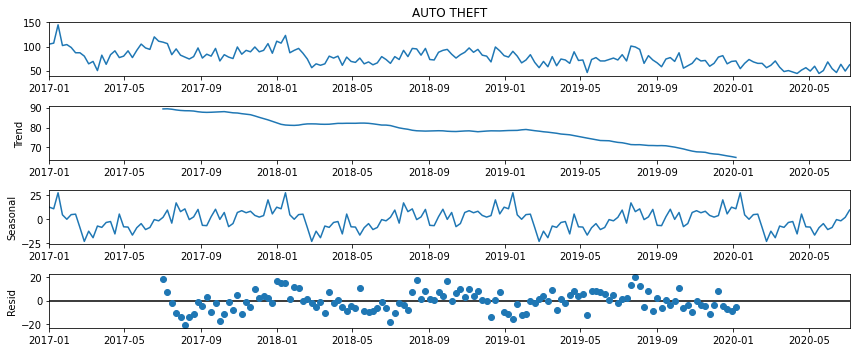

In [98]:
## Use Seasonal Decompose to check for seasonality 
decomp = tsa.seasonal_decompose(train)
decomp.plot();

>- **NOTE: I removed the use of any functions from the rest of the workflow** in order to make it more transparent as to what we are doing.
    - I HIGHLY recommend functionizing a lot of longer blocks of code that you will need to repeat for each model/zipcode/stock.

In [99]:
## Gridsearch params
auto_model = pmd.auto_arima(train,start_p=0,max_p=5,
                           start_q=0,max_q=5,d=1,m=52,
                           start_P=0,start_Q=0,verbose=True)
display(auto_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  184
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -704.057
Date:                             Mon, 14 Jun 2021   AIC                           1414.114
Time:                                     14:20:05   BIC                           1423.742
Sample:                                          0   HQIC                          1418.017
                                             - 184                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5836      0.057    -10.185      0.000      -0.696      -0.471
ar.S.L52       0.2670      0.085      3.152      0.002       0.101       0.433
sigma2       125.6408     13.405      9.372      0.000      99.367     151.915
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.64   Prob(JB):                         0.88
Heteroskedasticity (H):               0.66   Skew:                             0.09
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          AUTO THEFT   No. Observations:                  184
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -704.057
Date:                             Mon, 14 Jun 2021   AIC                           1414.114
Time:                                     14:20:06   BIC                           1423.742
Sample:                                 01-01-2017   HQIC                          1418.017
                                      - 07-05-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5835      0.057    -10.185      0.000      -0.696      -0.471
ar.S.L52       0.2670      0.085      3.152      0.002       0.101       0.433
sigma2       125.6412     13.405      9.372      0.000      99.367     151.916
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.64   Prob(JB):                         0.88
Heteroskedasticity (H):               0.66   Skew:                             0.09
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

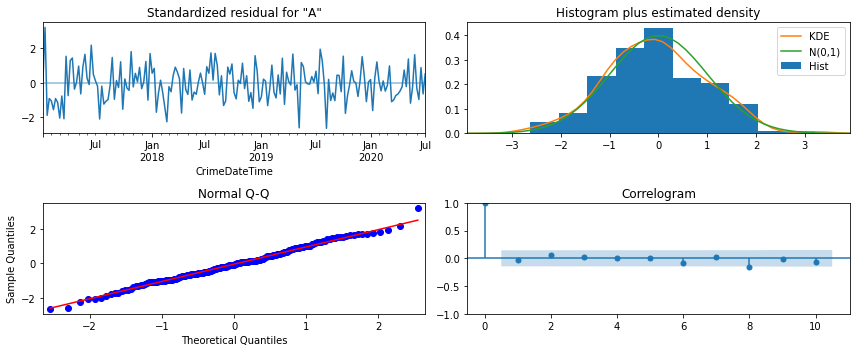

In [100]:
## Fit a final model and evaluate
best_model = tsa.SARIMAX(train,order=auto_model.order,
                seasonal_order = auto_model.seasonal_order,
                enforce_invertibility=False).fit()


## Display Summary + Diagnostics
display(best_model.summary())
best_model.plot_diagnostics();
plt.tight_layout()

In [103]:
ts_diff = ts.diff().dropna()
ts_diff

CrimeDateTime
2017-01-08 00:00:00+00:00     2.0
2017-01-15 00:00:00+00:00    38.0
2017-01-22 00:00:00+00:00   -43.0
2017-01-29 00:00:00+00:00     2.0
2017-02-05 00:00:00+00:00    -6.0
                             ... 
2021-04-25 00:00:00+00:00     9.0
2021-05-02 00:00:00+00:00    -6.0
2021-05-09 00:00:00+00:00     6.0
2021-05-16 00:00:00+00:00    -8.0
2021-05-23 00:00:00+00:00    -9.0
Freq: W-SUN, Name: AUTO THEFT, Length: 229, dtype: float64

In [105]:
ts.loc['01-08-2017':]

CrimeDateTime
2017-01-08 00:00:00+00:00    107
2017-01-15 00:00:00+00:00    145
2017-01-22 00:00:00+00:00    102
2017-01-29 00:00:00+00:00    104
2017-02-05 00:00:00+00:00     98
                            ... 
2021-04-25 00:00:00+00:00     59
2021-05-02 00:00:00+00:00     53
2021-05-09 00:00:00+00:00     59
2021-05-16 00:00:00+00:00     51
2021-05-23 00:00:00+00:00     42
Freq: W-SUN, Name: AUTO THEFT, Length: 229, dtype: int64

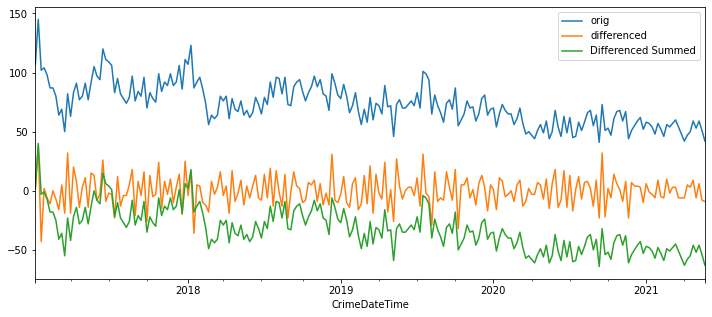

In [106]:
ax = ts.loc['01-08-2017':].plot(label='orig')

ts_diff.plot(label='differenced')
ts_diff.cumsum().plot(label='Differenced Summed')
ax.legend()

In [107]:
## Get forecast 
forecast = best_model.get_forecast(steps=len(test))

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df

Lower CI  Upper CI  Forecast
2020-07-12 00:00:00+00:00    33.118    77.057    55.088
2020-07-19 00:00:00+00:00    39.568    87.164    63.366
2020-07-26 00:00:00+00:00    37.335    88.328    62.832
2020-08-02 00:00:00+00:00    34.408    88.585    61.497
2020-08-09 00:00:00+00:00    25.161    82.344    53.752
2020-08-16 00:00:00+00:00    28.005    88.045    58.025
2020-08-23 00:00:00+00:00    24.239    87.005    55.622
2020-08-30 00:00:00+00:00    21.330    86.709    54.019
2020-09-06 00:00:00+00:00    17.938    85.829    51.883
2020-09-13 00:00:00+00:00    20.999    91.313    56.156
2020-09-20 00:00:00+00:00    20.629    93.285    56.957
2020-09-27 00:00:00+00:00    17.358    92.283    54.821
2020-10-04 00:00:00+00:00    21.064    98.191    59.627
2020-10-11 00:00:00+00:00    11.448    90.716    51.082
2020-10-18 00:00:00+00:00    11.741    93.093    52.417
2020-10-25 00:00:00+00:00    12.060    95.445    53.752
2020-11-01 00:00:00+00:00    14.005    99.374    56.690
2020-11-08 00:00:00+00:00    11.434    98.742    55.088
2020-11-15 00:00:00+00:00    10.752    99.957    55.355
2020-11-22 00:00:00+00:00     6.619    97.681    52.150
2020-11-29 00:00:00+00:00     7.311   100.194    53.752
2020-12-06 00:00:00+00:00     9.890   104.558    57.224
2020-12-13 00:00:00+00:00     9.815   106.235    58.025
2020-12-20 00:00:00+00:00     4.415   102.556    53.485
2020-12-27 00:00:00+00:00     4.904   104.737    54.821
2021-01-03 00:00:00+00:00     4.340   105.835    55.088
2021-01-10 00:00:00+00:00    -0.751   102.381    50.815
2021-01-17 00:00:00+00:00     1.381   106.124    53.752
2021-01-24 00:00:00+00:00     2.724   109.053    55.889
2021-01-31 00:00:00+00:00     0.608   108.499    54.554
2021-02-07 00:00:00+00:00    -0.964   108.469    53.752
2021-02-14 00:00:00+00:00    -1.723   109.228    53.752
2021-02-21 00:00:00+00:00    -4.876   107.574    51.349
2021-02-28 00:00:00+00:00    -4.280   109.649    52.684
2021-03-07 00:00:00+00:00    -2.607   112.782    55.088
2021-03-14 00:00:00+00:00    -6.800   110.032    51.616
2021-03-21 00:00:00+00:00    -9.915   108.341    49.213
2021-03-28 00:00:00+00:00   -10.085   109.578    49.747
2021-04-04 00:00:00+00:00   -11.581   109.473    48.946
2021-04-11 00:00:00+00:00   -13.070   109.359    48.145
2021-04-18 00:00:00+00:00   -11.881   111.908    50.014
2021-04-25 00:00:00+00:00   -11.218   113.916    51.349
2021-05-02 00:00:00+00:00   -13.753   112.712    49.480
2021-05-09 00:00:00+00:00   -11.741   116.041    52.150
2021-05-16 00:00:00+00:00   -16.398   112.687    48.145
2021-05-23 00:00:00+00:00   -15.441   114.935    49.747

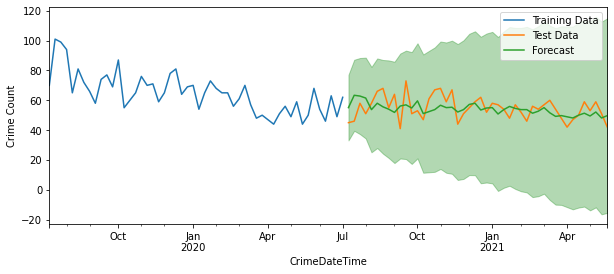

In [108]:
### PLot training data, and forecast (with upper/,lower ci)
last_n_lags=52

fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
train.iloc[-last_n_lags:].plot(label='Training Data')
test.plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)

ax.set(ylabel='Crime Count')
ax.legend()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          AUTO THEFT   No. Observations:                  230
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -869.807
Date:                             Mon, 14 Jun 2021   AIC                           1745.615
Time:                                     14:25:24   BIC                           1755.916
Sample:                                 01-01-2017   HQIC                          1749.771
                                      - 05-23-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5997      0.048    -12.464      0.000      -0.694      -0.505
ar.S.L52       0.2375      0.071      3.350      0.001       0.099       0.377
sigma2       114.8393     10.628     10.806      0.000      94.009     135.669
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.67   Prob(JB):                         0.90
Heteroskedasticity (H):               0.47   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

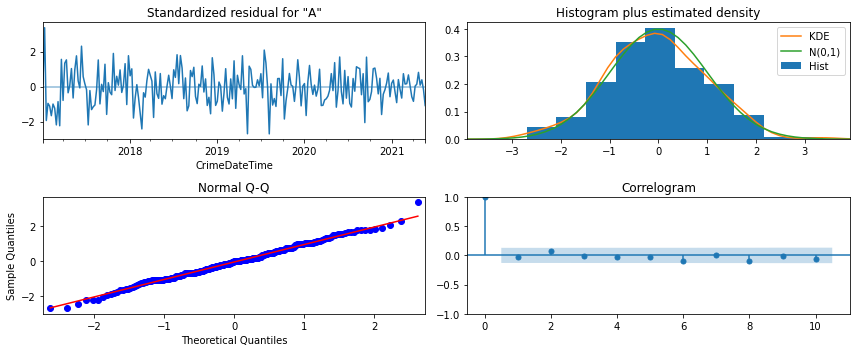

In [109]:
## If happy with the model's test perforamance, retrain on entire ts and forecast into future
## Fit a final model and evaluate
final_model = tsa.SARIMAX(ts,order=auto_model.order,
                seasonal_order = auto_model.seasonal_order,
                enforce_invertibility=False).fit()


## Display Summary + Diagnostics
display(final_model.summary())
final_model.plot_diagnostics();
plt.tight_layout()

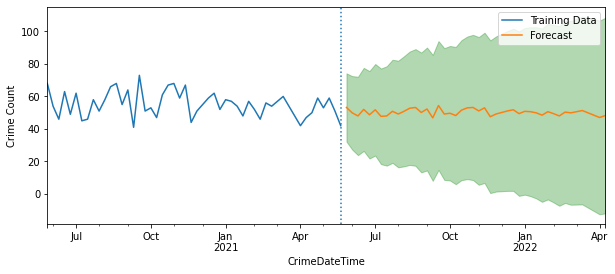

In [110]:
## Get forecast 
forecast = final_model.get_forecast(steps=len(test))

## save forecasted mean and upper/lower ci as df
forecast_df = forecast.conf_int()
forecast_df.columns = ['Lower CI','Upper CI']
forecast_df['Forecast'] = forecast.predicted_mean

## Plot
last_n_lags=52

fig,ax = plt.subplots(figsize=(10,4))

                      
# Plotting Training and test data
ts.iloc[-last_n_lags:].plot(label='Training Data')
ax.axvline(ts.index[-1],ls=':')
# test.plot(label='Test Data')

## Plotting Forefcast and CI
forecast_df['Forecast'].plot(ax=ax,label='Forecast')
ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)

ax.set(ylabel='Crime Count')
ax.legend()

## Summary


- Today we discussed the various types of time-series models:
    - AR/MA, ARIMA, SARIMA/SARIMAX.
    - We discussed how ACF/PACF can provide a hint for best params to use for our model. 
    - We also discussed how this info can be harder to see than we'd like. 
    - We introduced performing a gridsearch for our ts models using `pmdarima`

# Bonus: Stocks with Pandas DataReader

In [111]:
# !pip install pandas-datareader
import pandas_datareader as pdr

In [112]:
## List of symbols to grab
symbols = ['FB','AAPL','GOOGL','AMZN','MSFT']

data = {}
for stock in symbols:
    data[stock] = pdr.DataReader(stock,'yahoo','2012','2020')['Adj Close']
dfs = pd.DataFrame(data)
dfs

FB    AAPL     GOOGL     AMZN     MSFT
Date                                                  
2012-01-03     NaN  12.629   333.038   179.03   21.749
2012-01-04     NaN  12.697   334.474   177.51   22.261
2012-01-05     NaN  12.838   329.835   177.61   22.488
2012-01-06     NaN  12.972   325.335   182.61   22.838
2012-01-09     NaN  12.952   311.542   178.56   22.537
...            ...     ...       ...      ...      ...
2019-12-24  205.12  70.235  1344.430  1789.21  155.014
2019-12-26  207.79  71.628  1362.470  1868.77  156.285
2019-12-27  208.10  71.601  1354.640  1869.80  156.571
2019-12-30  204.41  72.026  1339.710  1846.89  155.221
2019-12-31  205.25  72.552  1339.390  1847.84  155.330

[2012 rows x 5 columns]